## Importing libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import glob
import time
import re

from sklearn import linear_model, model_selection, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve,roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

plt.style.use('seaborn')

In [ ]:
data = pd.read_csv('fake_job_postings.csv')

## Data preprocessing

In [ ]:
#split salary range into 2 new columns: lower_salary_range and higher_salary_range
data[['lower_salary_range','higher_salary_range']] = data.salary_range.str.split('-', expand=True)
data['lower_salary_range'] = data['lower_salary_range'].astype(float).astype('Int64')
data['higher_salary_range'] = data['higher_salary_range'].astype(float).astype('Int64')

#initialise new column: salary_range_difference
data['salary_range_difference'] = data['higher_salary_range'] - data['lower_salary_range']

#if salary range only contains a single value, set higher_salary_range = lower_salary_range
data.loc[data['salary_range'].notnull() & data['salary_range_difference'].isnull(), 'higher_salary_range'] = data['lower_salary_range']

#recalculate salary_range_difference
data['salary_range_difference'] = data['higher_salary_range'] - data['lower_salary_range']

#check if salary range present
data['salary_present'] = np.where(data.salary_range.notnull(), 1, 0)

#reposition columns
lower_salary_range = data.pop('lower_salary_range')
higher_salary_range = data.pop('higher_salary_range')
salary_range_difference = data.pop('salary_range_difference')
salary_present = data.pop('salary_present')

data.insert(4, "salary_present", salary_present)
data.insert(6, "lower_salary_range", lower_salary_range)
data.insert(7, "higher_salary_range", higher_salary_range)
data.insert(8, "salary_range_difference", salary_range_difference)

In [ ]:
#create country, state and city columns
location_data = data["location"].str.split(",", expand = True)

data["country"] = location_data[0]
data["state"] = location_data[1]
data["city"] = location_data[2]
 
country = data.pop('country')
state = data.pop('state')
city = data.pop('city')
data.insert(3, "country", country)
data.insert(4, "state", state)
data.insert(5, "city", city)

In [ ]:
data.head()

,job_id,title,location,country,state,city,department,salary_present,salary_range,lower_salary_range,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",US,NY,New York,Marketing,0,NaN,<NA>,...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",NZ,,Auckland,Success,0,NaN,<NA>,...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",US,IA,Wever,NaN,0,NaN,<NA>,...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",US,DC,Washington,Sales,0,NaN,<NA>,...,Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",US,FL,Fort Worth,NaN,0,NaN,<NA>,...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
numerical_variables = ['lower_salary_range', 'higher_salary_range', 'difference_salary_range']
cat_variables = ['country', 'state', 'city', 'salary_present', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education']

In [ ]:
notfraud_data = data[data["fraudulent"] == 0]
fraud_data = data[data["fraudulent"] == 1]

In [ ]:
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

job_id                      0.00
title                       0.00
location                    1.94
country                     1.94
state                       2.46
city                        2.46
department                 64.58
salary_present              0.00
salary_range               83.96
lower_salary_range         83.96
higher_salary_range        83.96
salary_range_difference    83.96
company_profile            18.50
description                 0.01
requirements               15.07
benefits                   40.32
telecommuting               0.00
has_company_logo            0.00
has_questions               0.00
employment_type            19.41
required_experience        39.43
required_education         45.33
industry                   27.42
function                   36.10
fraudulent                  0.00
dtype: float64

In [ ]:
((fraud_data.isnull() | fraud_data.isna()).sum() * 100 / fraud_data.index.size).round(2)

job_id                      0.00
title                       0.00
location                    2.19
country                     2.19
state                       3.12
city                        3.12
department                 61.32
salary_present              0.00
salary_range               74.25
lower_salary_range         74.25
higher_salary_range        74.25
salary_range_difference    74.25
company_profile            67.78
description                 0.12
requirements               17.78
benefits                   42.03
telecommuting               0.00
has_company_logo            0.00
has_questions               0.00
employment_type            27.83
required_experience        50.23
required_education         52.08
industry                   31.76
function                   38.91
fraudulent                  0.00
dtype: float64

In [ ]:
((notfraud_data.isnull() | notfraud_data.isna()).sum() * 100 / notfraud_data.index.size).round(2)

job_id                      0.00
title                       0.00
location                    1.92
country                     1.92
state                       2.43
city                        2.43
department                 64.75
salary_present              0.00
salary_range               84.45
lower_salary_range         84.45
higher_salary_range        84.45
salary_range_difference    84.45
company_profile            15.99
description                 0.00
requirements               14.93
benefits                   40.24
telecommuting               0.00
has_company_logo            0.00
has_questions               0.00
employment_type            18.98
required_experience        38.88
required_education         44.99
industry                   27.20
function                   35.96
fraudulent                  0.00
dtype: float64

In [ ]:
#fill missing values for location, department, requirements, employment_type, required_experience, required_education, industry, function
data['location'].fillna("Unspecified", inplace=True)
data['department'].fillna("Unspecified", inplace=True)
data['requirements'].fillna("Unspecified", inplace=True)
data['employment_type'].fillna("Unspecified", inplace=True)
data['required_experience'].fillna("Unspecified", inplace=True)
data['required_education'].fillna("Unspecified", inplace=True)
data['industry'].fillna("Unspecified", inplace=True)
data['function'].fillna("Unspecified", inplace=True)
data['description'].fillna("Unspecified", inplace=True)
data['company_profile'].fillna("Unspecified", inplace=True)

In [ ]:
#one hot encoding for employment_type
encoder = OneHotEncoder()
encoder_employment = pd.DataFrame(encoder.fit_transform(data[['employment_type']]).toarray())
encoder_employment.columns = ['ep_contract', 'ep_full-time', 'ep_other', 'ep_part-time', 'ep_temporary', 'ep_unspecified']
print(encoder_employment)

       ep_contract  ep_full-time  ep_other  ep_part-time  ep_temporary  \
0              0.0           0.0       1.0           0.0           0.0   
1              0.0           1.0       0.0           0.0           0.0   
2              0.0           0.0       0.0           0.0           0.0   
3              0.0           1.0       0.0           0.0           0.0   
4              0.0           1.0       0.0           0.0           0.0   
...            ...           ...       ...           ...           ...   
17875          0.0           1.0       0.0           0.0           0.0   
17876          0.0           1.0       0.0           0.0           0.0   
17877          0.0           1.0       0.0           0.0           0.0   
17878          1.0           0.0       0.0           0.0           0.0   
17879          0.0           1.0       0.0           0.0           0.0   

       ep_unspecified  
0                 0.0  
1                 0.0  
2                 1.0  
3              

In [ ]:
#one hot encoding for required_experience
encoder = OneHotEncoder()
encoder_experience = pd.DataFrame(encoder.fit_transform(data[['required_experience']]).toarray())
encoder_experience.columns = ['exp_associate', 'exp_director', 'exp_entry level', 'exp_executive', 'exp_internship', 'exp_mid-senior level', 'exp_not applicable', 'exp_unspecified']
print(encoder_experience)

       exp_associate  exp_director  exp_entry level  exp_executive  \
0                0.0           0.0              0.0            0.0   
1                0.0           0.0              0.0            0.0   
2                0.0           0.0              0.0            0.0   
3                0.0           0.0              0.0            0.0   
4                0.0           0.0              0.0            0.0   
...              ...           ...              ...            ...   
17875            0.0           0.0              0.0            0.0   
17876            0.0           0.0              0.0            0.0   
17877            0.0           0.0              0.0            0.0   
17878            0.0           0.0              0.0            0.0   
17879            0.0           0.0              0.0            0.0   

       exp_internship  exp_mid-senior level  exp_not applicable  \
0                 1.0                   0.0                 0.0   
1                 0.0    

In [ ]:
#one hot encoding for required_education
encoder = OneHotEncoder()
encoder_education = pd.DataFrame(encoder.fit_transform(data[['required_education']]).toarray())
encoder_education.columns = ['edu_associate degree', 'edu_bachelor degree', 'edu_certification', 'edu_doctorate', 'edu_high school', 'edu_masters', 'edu_professional', 'edu_some college coursework', 'edu_some high sch coursework', 'edu_unspecified', 'edu_vocational', 'edu_vocational degree', 'edu_vocational hs diploma']
print(encoder_education)

       edu_associate degree  edu_bachelor degree  edu_certification  \
0                       0.0                  0.0                0.0   
1                       0.0                  0.0                0.0   
2                       0.0                  0.0                0.0   
3                       0.0                  1.0                0.0   
4                       0.0                  1.0                0.0   
...                     ...                  ...                ...   
17875                   0.0                  0.0                0.0   
17876                   0.0                  1.0                0.0   
17877                   0.0                  0.0                0.0   
17878                   0.0                  0.0                0.0   
17879                   0.0                  0.0                0.0   

       edu_doctorate  edu_high school  edu_masters  edu_professional  \
0                0.0              0.0          0.0               0.0   
1  

In [ ]:
#data.to_csv('data.csv', index = False)

In [ ]:
#insert encoded columns into data
partial_existing_data = data.iloc[:, :20]

added_empcategory = partial_existing_data.join(encoder_employment)
add_existing_data = added_empcategory.join(data.iloc[:, 20:21])

added_expcategory = add_existing_data.join(encoder_experience)
add_existing_data2 = added_expcategory.join(data.iloc[:, 21:22])

added_educategory = add_existing_data2.join(encoder_education)
new_data = added_educategory.join(data.iloc[:, 22:])

In [ ]:
#new_data.to_csv('new_data.csv', index = False)

## Splitting data into Train/Validation/Test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(['fraudulent'], axis=1), new_data['fraudulent'], test_size=0.1, random_state=0)

In [ ]:
#X_train.head()

## Feature engineering

In [ ]:
#descriptive statistics of salary-related columns in training dataset (before outlier removal)
stats = X_train[['lower_salary_range', 'higher_salary_range', 'salary_range_difference']].describe()
stats['lower_salary_range'] = stats['lower_salary_range'].astype('int64')
stats['higher_salary_range'] = stats['higher_salary_range'].astype('int64')
stats['salary_range_difference'] = stats['salary_range_difference'].astype('int64')
stats

,lower_salary_range,higher_salary_range,salary_range_difference
count,2575,2575,2575
mean,563547,884106,320558
std,18587458,28419473,9863672
min,0,0,0
25%,18000,25000,3087
50%,35000,50000,10000
75%,60000,85000,22000
max,800000000,1200000000,400000000


In [ ]:
#remove rows with missing salary range to calculate outliers
X_train_with_salary = X_train.dropna(subset=['salary_range'])

#calculate interquartile range
lower_q25, lower_q75 = np.percentile(X_train_with_salary['lower_salary_range'], 25), np.percentile(X_train_with_salary['lower_salary_range'], 75)
lower_iqr = lower_q75 - lower_q25

higher_q25, higher_q75 = np.percentile(X_train_with_salary['higher_salary_range'], 25), np.percentile(X_train_with_salary['higher_salary_range'], 75)
higher_iqr = higher_q75 - higher_q25

saldiff_q25, saldiff_q75 = np.percentile(X_train_with_salary['salary_range_difference'], 25), np.percentile(X_train_with_salary['salary_range_difference'], 75)
saldiff_iqr = saldiff_q75 - saldiff_q25

#calculate the outlier cutoff
lower_cut_off = lower_iqr * 1.5
higher_cut_off = higher_iqr * 1.5
saldiff_cut_off = saldiff_iqr * 1.5

lower_lower, lower_upper = lower_q25 - lower_cut_off, lower_q75 + lower_cut_off
higher_lower, higher_upper = higher_q25 - higher_cut_off, higher_q75 + higher_cut_off
saldiff_lower, saldiff_upper = saldiff_q25 - saldiff_cut_off, saldiff_q75 + saldiff_cut_off

print(lower_lower)
print(lower_upper)
print(higher_lower)
print(higher_upper)
print(saldiff_lower)
print(saldiff_upper)

-45000.0
123000.0
-65000.0
175000.0
-25281.25
50368.75


In [ ]:
#remove outliers
X_train_sal_lower = X_train_with_salary[(X_train_with_salary['lower_salary_range'] <= lower_upper)]
X_train_sal_higher = X_train_with_salary[(X_train_with_salary['higher_salary_range'] <= higher_upper)]
X_train_sal_diff = X_train_with_salary[(X_train_with_salary['salary_range_difference'] <= saldiff_upper)]

In [ ]:
#descriptive statistics of salary related columns (after outlier removal)
lower_stats = X_train_sal_lower['lower_salary_range'].describe()
lower_stats['lower_salary_range'] = stats['lower_salary_range'].astype('int64')
print(lower_stats)

higher_stats = X_train_sal_higher['higher_salary_range'].describe()
higher_stats['higher_salary_range'] = stats['higher_salary_range'].astype('int64')

saldiff_stats = X_train_sal_diff['salary_range_difference'].describe()
saldiff_stats['salary_range_difference'] = stats['salary_range_difference'].astype('int64')

count                                                            2429.0
mean                                                       37059.208728
std                                                        28644.434329
min                                                                 0.0
25%                                                             16000.0
50%                                                             34000.0
75%                                                             50000.0
max                                                            120000.0
lower_salary_range    count         2575
mean        563547
std     ...
Name: lower_salary_range, dtype: object


In [ ]:
print(higher_stats)

count                                                             2419.0
mean                                                        53130.653989
std                                                         40148.727196
min                                                                  0.0
25%                                                              24000.0
50%                                                              47000.0
75%                                                              80000.0
max                                                             175000.0
higher_salary_range    count          2575
mean         884106
std   ...
Name: higher_salary_range, dtype: object


In [ ]:
print(saldiff_stats)

count                                                                 2338.0
mean                                                             12756.86698
std                                                             12417.641456
min                                                                      0.0
25%                                                                   2500.0
50%                                                                  10000.0
75%                                                                  20000.0
max                                                                  50000.0
salary_range_difference    count         2575
mean        320558
std     ...
Name: salary_range_difference, dtype: object


In [ ]:
datasets = [X_train, X_test]

In [ ]:
#convert back to float
for dataset in datasets:
    dataset.lower_salary_range = dataset.lower_salary_range.astype('float')
    dataset.higher_salary_range = dataset.higher_salary_range.astype('float')
    dataset.salary_range_difference = dataset.salary_range_difference.astype('float')

In [ ]:
#values below are obtained from calculations above
#split lower_salary_range into categories
#lower_salary_range <= 16000: low
#16000 < lower_salary_range <= 50000: average
#50000 < lower_salary_range <= 120000: high 
#lower_salary_range > 120000: outlier
#NA: Unspecified

for dataset in datasets:
    dataset['lower_salary_range_category'] = dataset['lower_salary_range']
    dataset.loc[dataset['lower_salary_range'].isnull(), 'lower_salary_range_category'] = "Unspecified"
    dataset.loc[dataset['lower_salary_range'] <= 16000, 'lower_salary_range_category'] = "Low"
    dataset.loc[(16000 < dataset['lower_salary_range']) & (dataset['lower_salary_range'] <= 50000), 'lower_salary_range_category'] = "Average"
    dataset.loc[(50000 < dataset['lower_salary_range']) & (dataset['lower_salary_range'] <= 120000), 'lower_salary_range_category'] = "High"
    dataset.loc[(dataset['lower_salary_range'] > 120000), 'lower_salary_range_category'] = "Outlier"

#split higher_salary_range into categories
#higher_salary_range <= 24000: low
#24000 < higher_salary_range <= 80000: average
#80000 < higher_salary_range <= 175000: high
#higher_salary_range > 175000: outlier
#NA: Unspecified
    dataset['higher_salary_range_category'] = dataset['higher_salary_range']
    dataset.loc[dataset['higher_salary_range'].isnull(), 'higher_salary_range_category'] = "Unspecified"
    dataset.loc[dataset['higher_salary_range'] <= 24000, 'higher_salary_range_category'] = "Low"
    dataset.loc[(24000 < dataset['higher_salary_range']) & (dataset['higher_salary_range'] <= 80000), 'higher_salary_range_category'] = "Average"
    dataset.loc[(80000 < dataset['higher_salary_range']) & (dataset['higher_salary_range'] <= 175000), 'higher_salary_range_category'] = "High"
    dataset.loc[(dataset['higher_salary_range'] > 175000), 'higher_salary_range_category'] = "Outlier"

#split salary_range_difference into categories
#salary_range_difference <= 2500: low
#2500 < salary_range_difference <= 20000: average
#20000 < salary_range_difference <= 50000: high
#salary_range_difference > 50000: outlier
#NA: Unspecified
    dataset['salary_range_difference_category'] = dataset['salary_range_difference']
    dataset.loc[dataset['salary_range_difference'].isnull(), 'salary_range_difference_category'] = "Unspecified"
    dataset.loc[dataset['salary_range_difference'] <= 2500, 'salary_range_difference_category'] = "Low"
    dataset.loc[(2500 < dataset['salary_range_difference']) & (dataset['salary_range_difference'] <= 20000), 'salary_range_difference_category'] = "Average"
    dataset.loc[(20000 < dataset['salary_range_difference']) & (dataset['salary_range_difference'] <= 50000), 'salary_range_difference_category'] = "High"
    dataset.loc[(dataset['salary_range_difference'] > 50000), 'salary_range_difference_category'] = "Outlier"

In [ ]:
#reposition columns
for dataset in datasets:
    lower_salary_range_category = dataset.pop('lower_salary_range_category')
    higher_salary_range_category = dataset.pop('higher_salary_range_category')
    salary_range_difference_category = dataset.pop('salary_range_difference_category')

    dataset.insert(10, "lower_salary_range_category", lower_salary_range_category)
    dataset.insert(12, "higher_salary_range_category", higher_salary_range_category)
    dataset.insert(14, "salary_range_difference_category", salary_range_difference_category)

In [ ]:
#one hot encoding for lower_salary_range_category
encoder = OneHotEncoder()
X_train_encoder_lowsal = pd.DataFrame(encoder.fit_transform(X_train[['lower_salary_range_category']]).toarray())
X_train_encoder_lowsal.columns = ['lowsal_average', 'lowsal_high', 'lowsal_low', 'lowsal_outlier', 'lowsal_unspecified']

encoder = OneHotEncoder()
X_test_encoder_lowsal = pd.DataFrame(encoder.fit_transform(X_test[['lower_salary_range_category']]).toarray())
X_test_encoder_lowsal.columns = ['lowsal_average', 'lowsal_high', 'lowsal_low', 'lowsal_outlier', 'lowsal_unspecified']

# encoder = OneHotEncoder()
# X_val_encoder_lowsal = pd.DataFrame(encoder.fit_transform(X_val[['lower_salary_range_category']]).toarray())
# X_val_encoder_lowsal.columns = ['lowsal_average', 'lowsal_high', 'lowsal_low', 'lowsal_outlier', 'lowsal_unspecified']

In [ ]:
#one hot encoding for higher_salary_range_category
encoder = OneHotEncoder()
X_train_encoder_highsal = pd.DataFrame(encoder.fit_transform(X_train[['higher_salary_range_category']]).toarray())
X_train_encoder_highsal.columns = ['highsal_average', 'highsal_high', 'highsal_low', 'highsal_outlier', 'highsal_unspecified']

encoder = OneHotEncoder()
X_test_encoder_highsal = pd.DataFrame(encoder.fit_transform(X_test[['higher_salary_range_category']]).toarray())
X_test_encoder_highsal.columns = ['highsal_average', 'highsal_high', 'highsal_low', 'highsal_outlier', 'highsal_unspecified']

# encoder = OneHotEncoder()
# X_val_encoder_highsal = pd.DataFrame(encoder.fit_transform(X_val[['higher_salary_range_category']]).toarray())
# X_val_encoder_highsal.columns = ['highsal_average', 'highsal_high', 'highsal_low', 'highsal_outlier', 'highsal_unspecified']

In [ ]:
# #one hot encoding for salary_range_difference_category
encoder = OneHotEncoder()
X_train_encoder_saldiff = pd.DataFrame(encoder.fit_transform(X_train[['salary_range_difference_category']]).toarray())
X_train_encoder_saldiff.columns = ['saldiff_average', 'saldiff_high', 'saldiff_low', 'saldiff_outlier', 'saldiff_unspecified']

encoder = OneHotEncoder()
X_test_encoder_saldiff = pd.DataFrame(encoder.fit_transform(X_test[['salary_range_difference_category']]).toarray())
X_test_encoder_saldiff.columns = ['saldiff_average', 'saldiff_high', 'saldiff_low', 'saldiff_outlier', 'saldiff_unspecified']

# encoder = OneHotEncoder()
# X_val_encoder_saldiff = pd.DataFrame(encoder.fit_transform(X_val[['salary_range_difference_category']]).toarray())
# X_val_encoder_saldiff.columns = ['saldiff_average', 'saldiff_high', 'saldiff_low', 'saldiff_outlier', 'saldiff_unspecified']

In [ ]:
#create final train data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
partial_existing_data = X_train.iloc[:, :11]

added_lowsalcategory = partial_existing_data.join(X_train_encoder_lowsal)
add_existing_data1 = added_lowsalcategory.join(X_train.iloc[:, 11:13])

added_highsalcategory = add_existing_data1.join(X_train_encoder_highsal)
add_existing_data2 = added_highsalcategory.join(X_train.iloc[:, 13:15])

added_saldiffcategory = add_existing_data2.join(X_train_encoder_saldiff)
X_train = added_saldiffcategory.join(X_train.iloc[:, 15:])

In [ ]:
#create final test data
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
partial_existing_data = X_test.iloc[:, :11]

added_lowsalcategory = partial_existing_data.join(X_test_encoder_lowsal)
add_existing_data1 = added_lowsalcategory.join(X_test.iloc[:, 11:13])

added_highsalcategory = add_existing_data1.join(X_test_encoder_highsal)
add_existing_data2 = added_highsalcategory.join(X_test.iloc[:, 13:15])

added_saldiffcategory = add_existing_data2.join(X_test_encoder_saldiff)
X_test = added_saldiffcategory.join(X_test.iloc[:, 15:])

In [ ]:
#create final val data
# X_val.reset_index(drop=True, inplace=True)
# y_val.reset_index(drop=True, inplace=True)
# partial_existing_data = X_val.iloc[:, :11]

# added_lowsalcategory = partial_existing_data.join(X_val_encoder_lowsal)
# add_existing_data1 = added_lowsalcategory.join(X_val.iloc[:, 11:13])

# added_highsalcategory = add_existing_data1.join(X_val_encoder_highsal)
# add_existing_data2 = added_highsalcategory.join(X_val.iloc[:, 13:15])

# added_saldiffcategory = add_existing_data2.join(X_val_encoder_saldiff)
# X_val = added_saldiffcategory.join(X_val.iloc[:, 15:])

In [ ]:
train_df = X_train
train_df['fraudulent'] = y_train
notfraud_data = train_df[train_df["fraudulent"] == 0]
fraud_data = train_df[train_df["fraudulent"] == 1]

In [ ]:
def get_top_unigrams(corpus, n=10):
    cv = CountVectorizer(stop_words='english')
    bow = cv.fit_transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_bigrams(corpus, n=10):
    cv = CountVectorizer(ngram_range=(2,2),stop_words='english')
    bow = cv.fit_transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

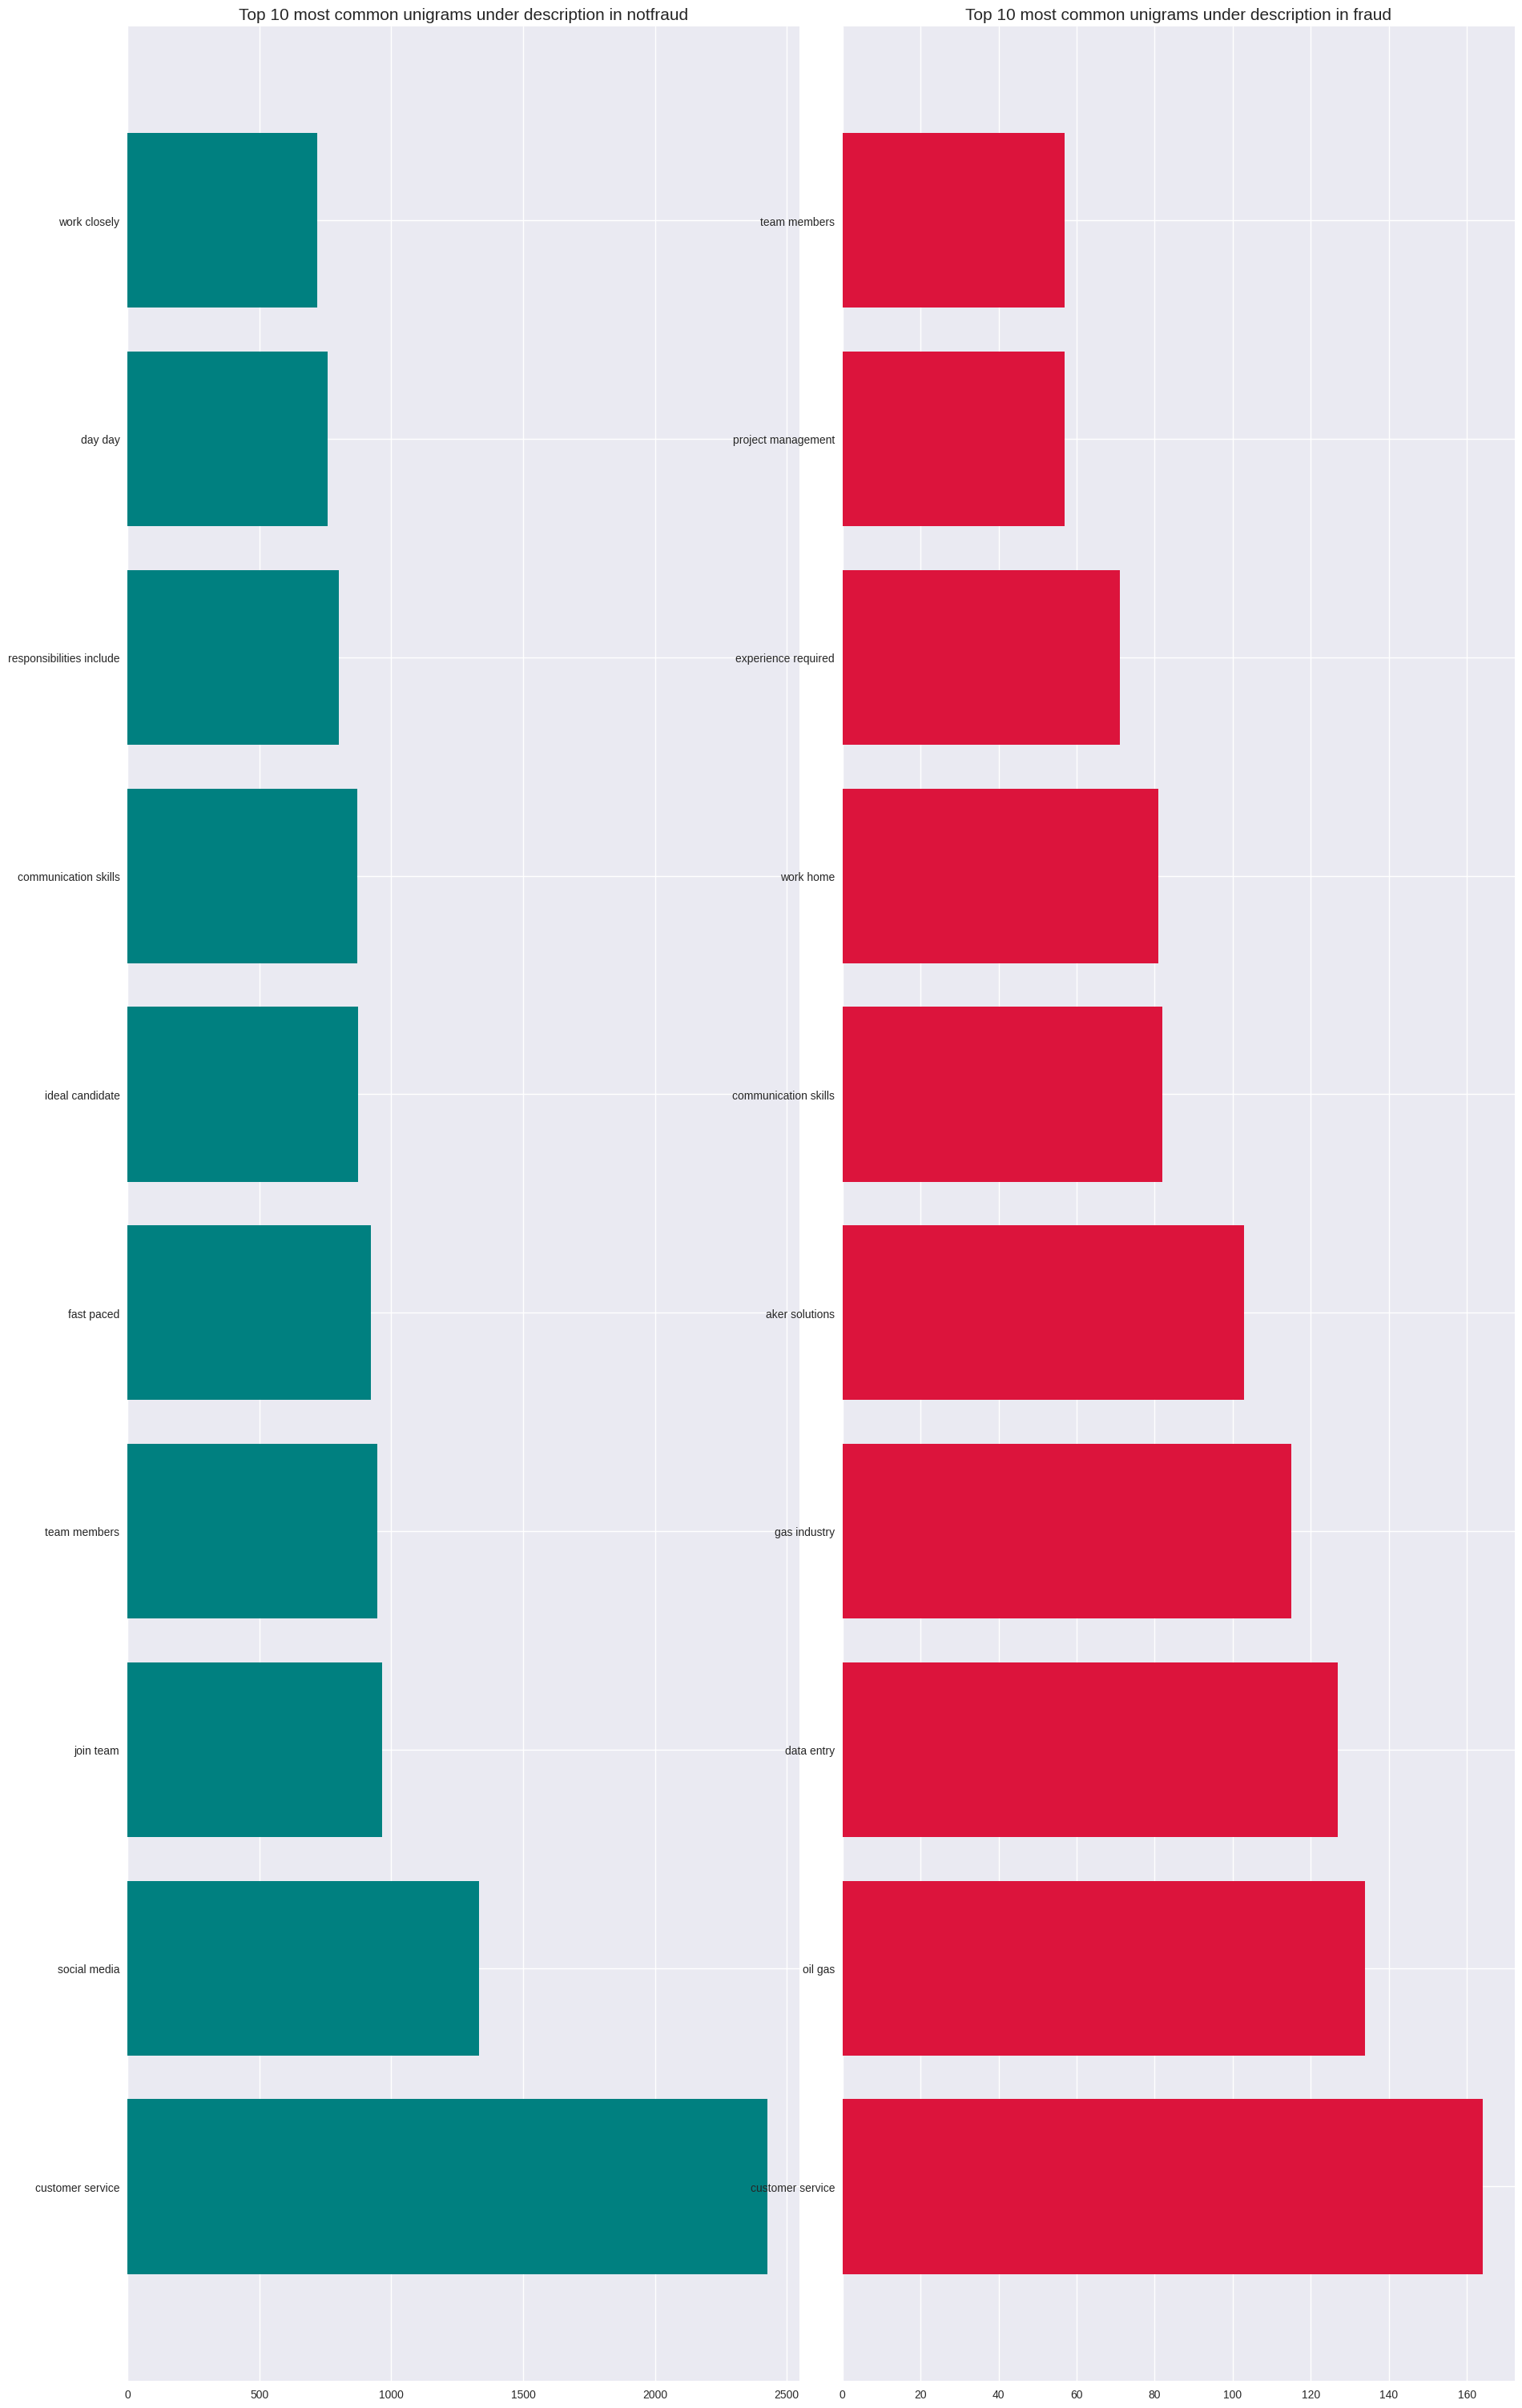

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

bigrams_notfraud=get_top_bigrams(notfraud_data['description'])
x,y=map(list,zip(*bigrams_notfraud))
axes[0].barh(x,y, color='teal')

bigrams_fraud=get_top_bigrams(fraud_data['description'])
x,y=map(list,zip(*bigrams_fraud))
axes[1].barh(x,y, color='crimson')

axes[0].set_title('Top 10 most common unigrams under description in notfraud', fontsize=15)
axes[1].set_title('Top 10 most common unigrams under description in fraud', fontsize=15)

plt.show()

In [ ]:
def get_cosine_sim(top_unigrams, corpus, n=10):
    tfidf = TfidfVectorizer()
    sparse_matrix = tfidf.fit_transform([corpus] + top_unigrams)
    cosine = cosine_similarity(sparse_matrix[0,:],sparse_matrix[1:,:])
    return cosine.sum()

In [ ]:
print(fraud_data['description'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x)).mean())
print(notfraud_data['description'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x)).mean())

0.21679061532204302
0.14322710536858652


In [ ]:
X_train['description_cosine_sim'] = X_train['description'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
X_test['description_cosine_sim'] = X_test['description'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
#X_val['description_cosine_sim'] = X_val['description'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))

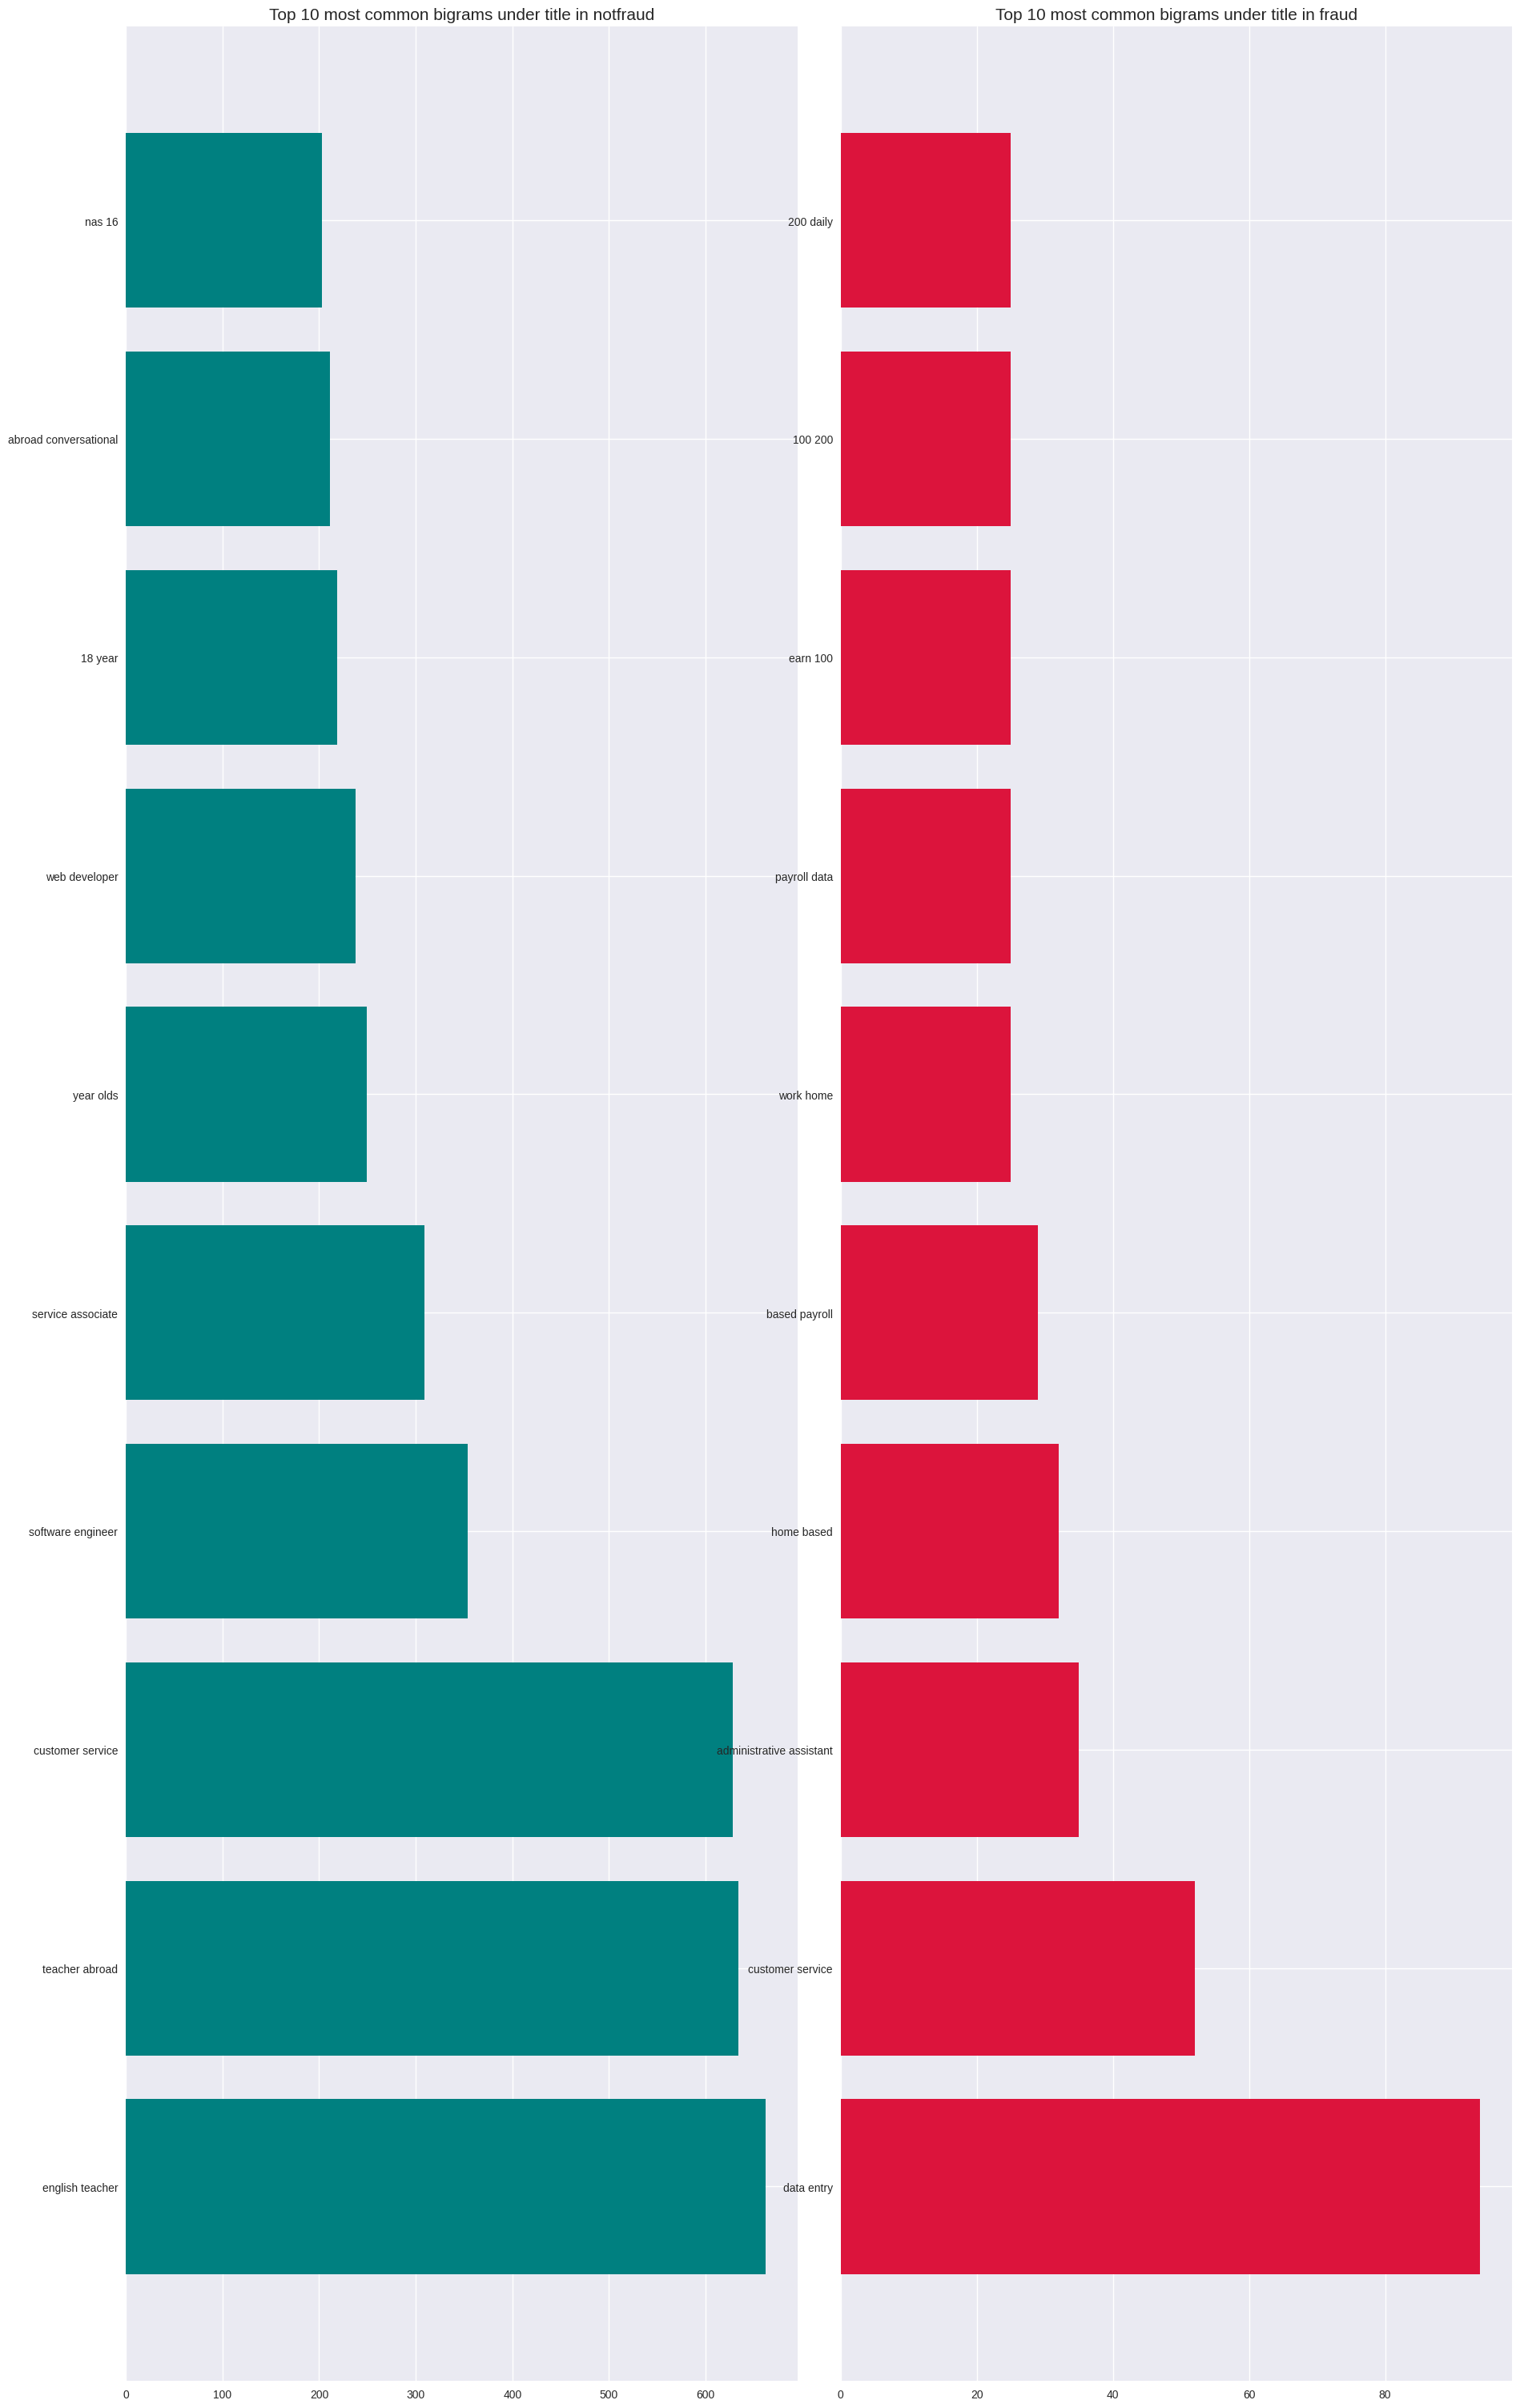

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

bigrams_notfraud=get_top_bigrams(notfraud_data['title'])
x,y=map(list,zip(*bigrams_notfraud))
axes[0].barh(x,y, color='teal')

bigrams_fraud=get_top_bigrams(fraud_data['title'])
x,y=map(list,zip(*bigrams_fraud))
axes[1].barh(x,y, color='crimson')

axes[0].set_title('Top 10 most common bigrams under title in notfraud', fontsize=15)
axes[1].set_title('Top 10 most common bigrams under title in fraud', fontsize=15)

plt.show()

In [ ]:
print(fraud_data['title'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x)).mean())
print(notfraud_data['title'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x)).mean())

0.3587598010445488
0.06463595718119892


In [ ]:
X_train['title_cosine_sim'] = X_train['title'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
X_test['title_cosine_sim'] = X_test['title'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
#X_val['title_cosine_sim'] = X_val['title'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))

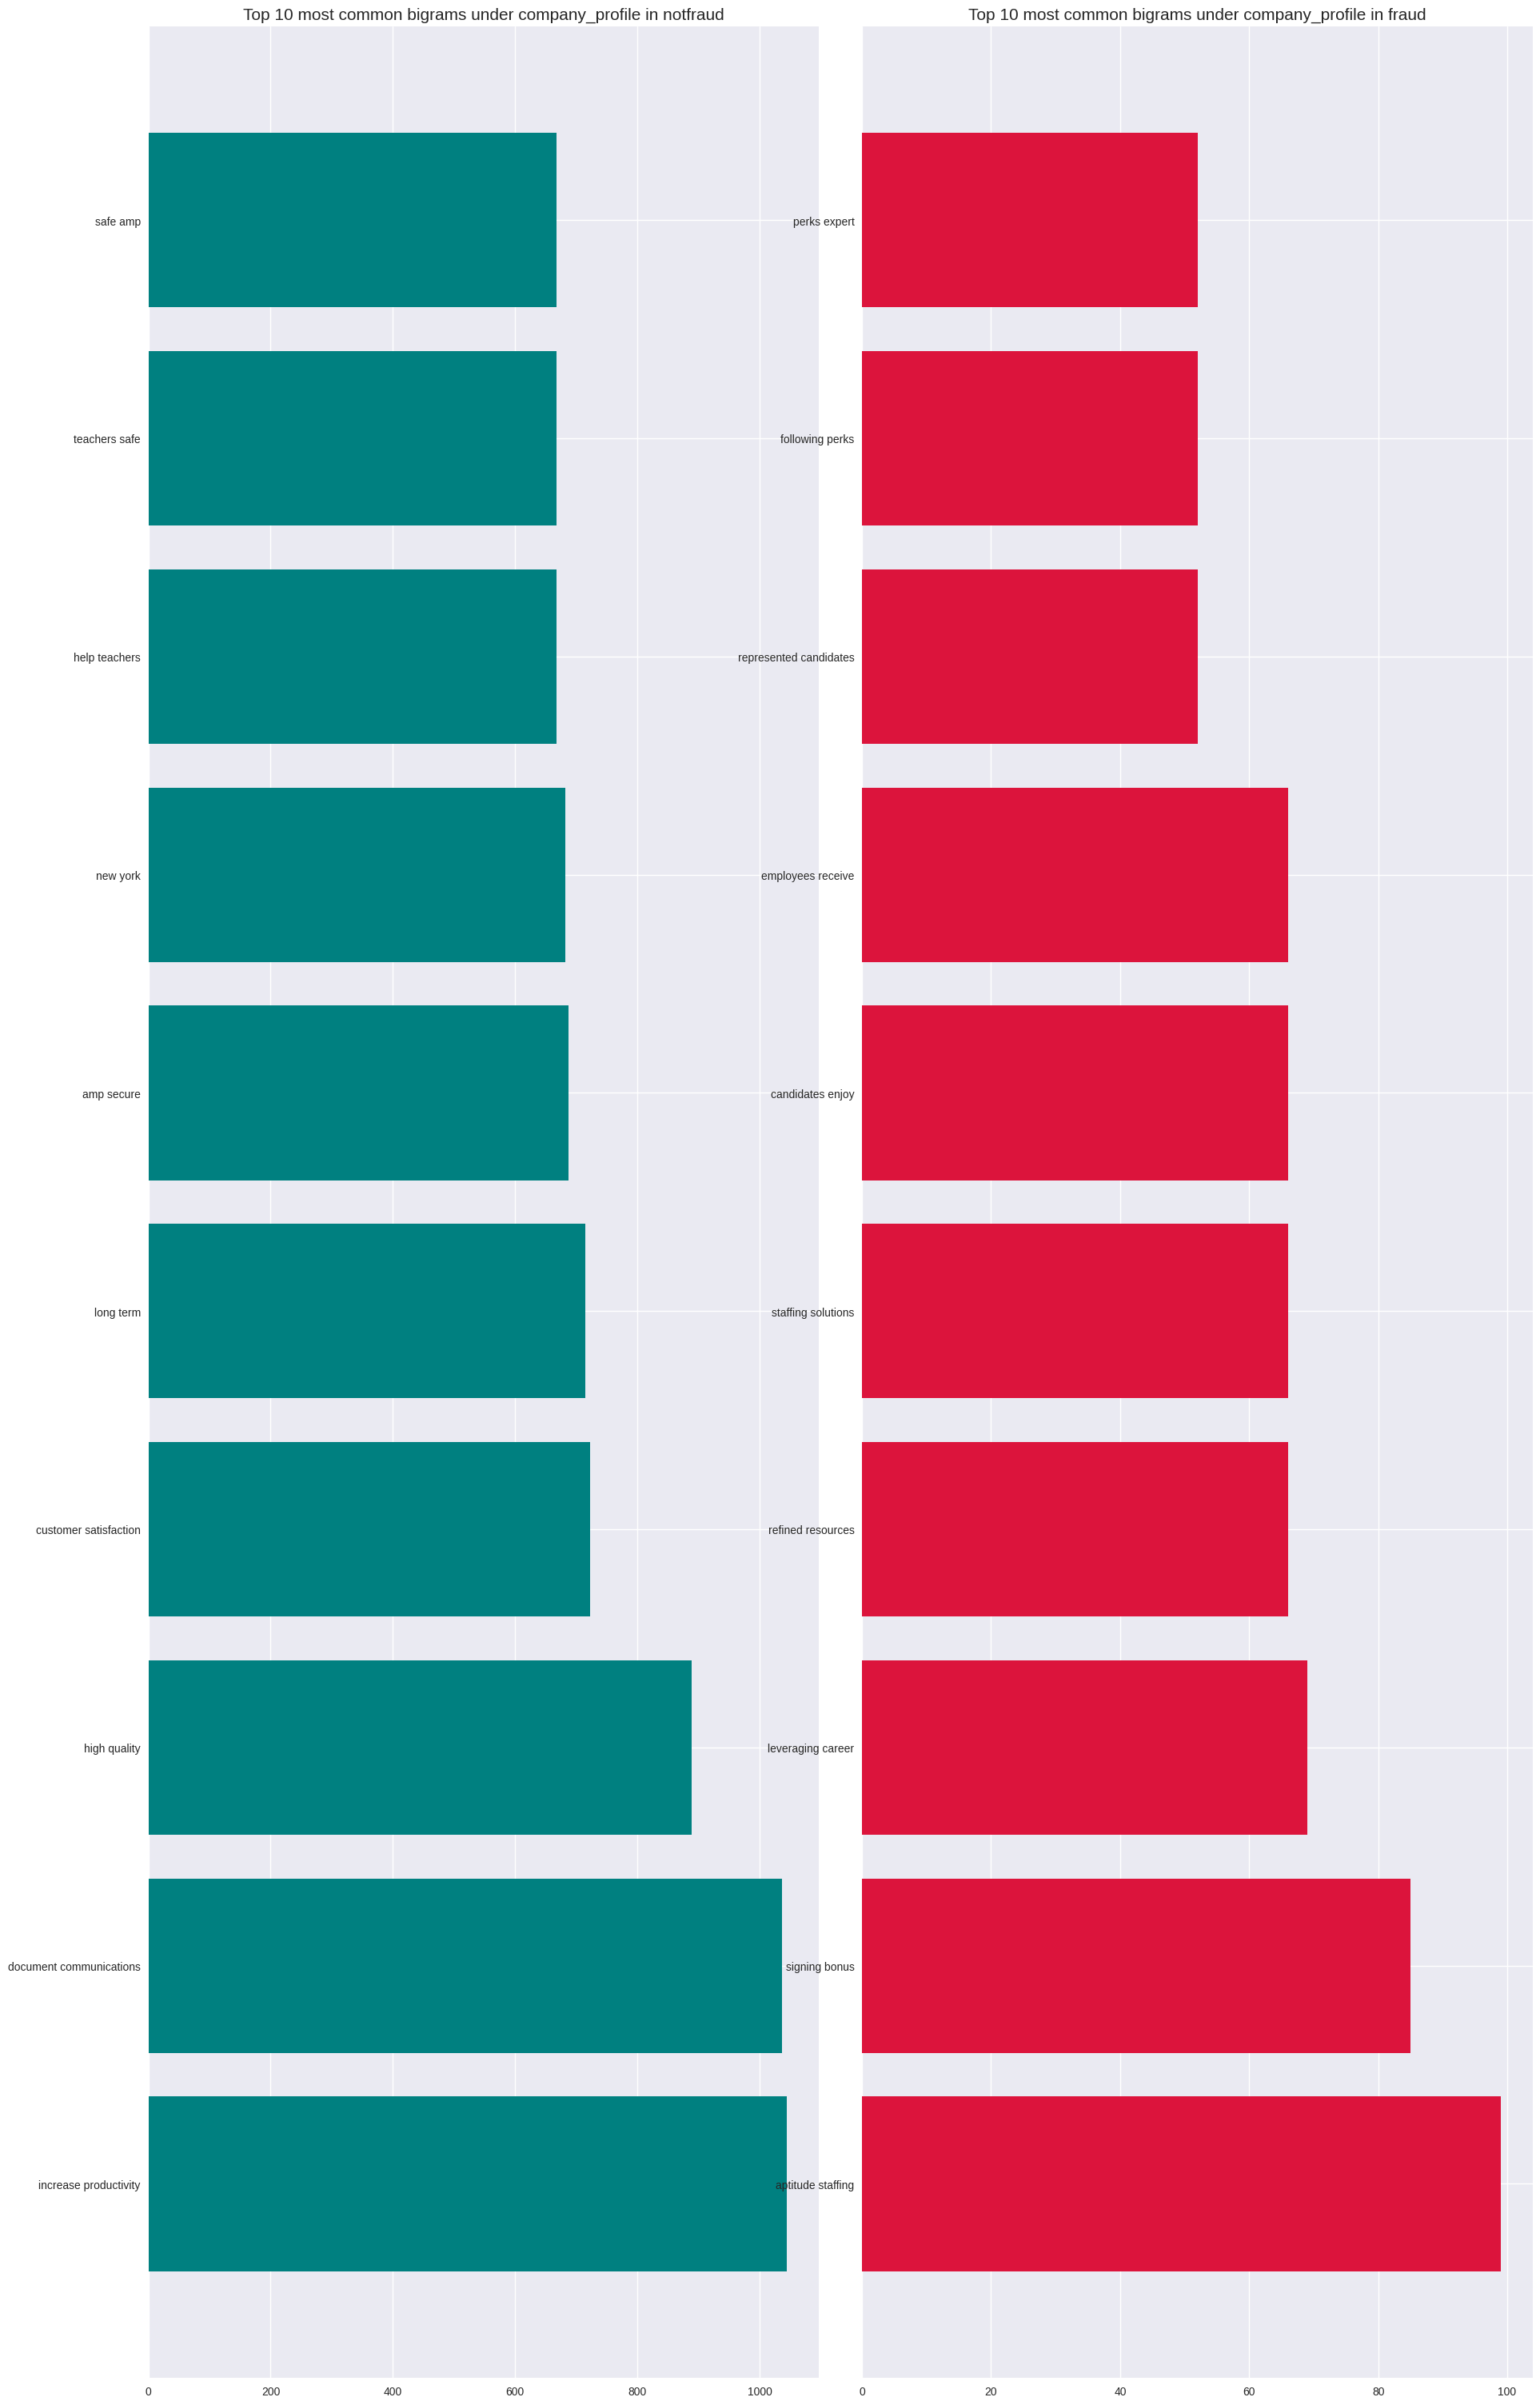

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

bigrams_notfraud=get_top_bigrams(notfraud_data['company_profile'])
x,y=map(list,zip(*bigrams_notfraud))
axes[0].barh(x,y, color='teal')

bigrams_fraud=get_top_bigrams(fraud_data['company_profile'])
x,y=map(list,zip(*bigrams_fraud))
axes[1].barh(x,y, color='crimson')

axes[0].set_title('Top 10 most common bigrams under company_profile in notfraud', fontsize=15)
axes[1].set_title('Top 10 most common bigrams under company_profile in fraud', fontsize=15)

plt.show()

In [ ]:
print(fraud_data['company_profile'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x)).mean())
print(notfraud_data['company_profile'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x)).mean())

0.09001233276943356
0.035334762986648685


In [ ]:
X_train['cp_cosine_sim'] = X_train['company_profile'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
X_test['cp_cosine_sim'] = X_test['company_profile'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
#X_val['cp_cosine_sim'] = X_val['company_profile'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))

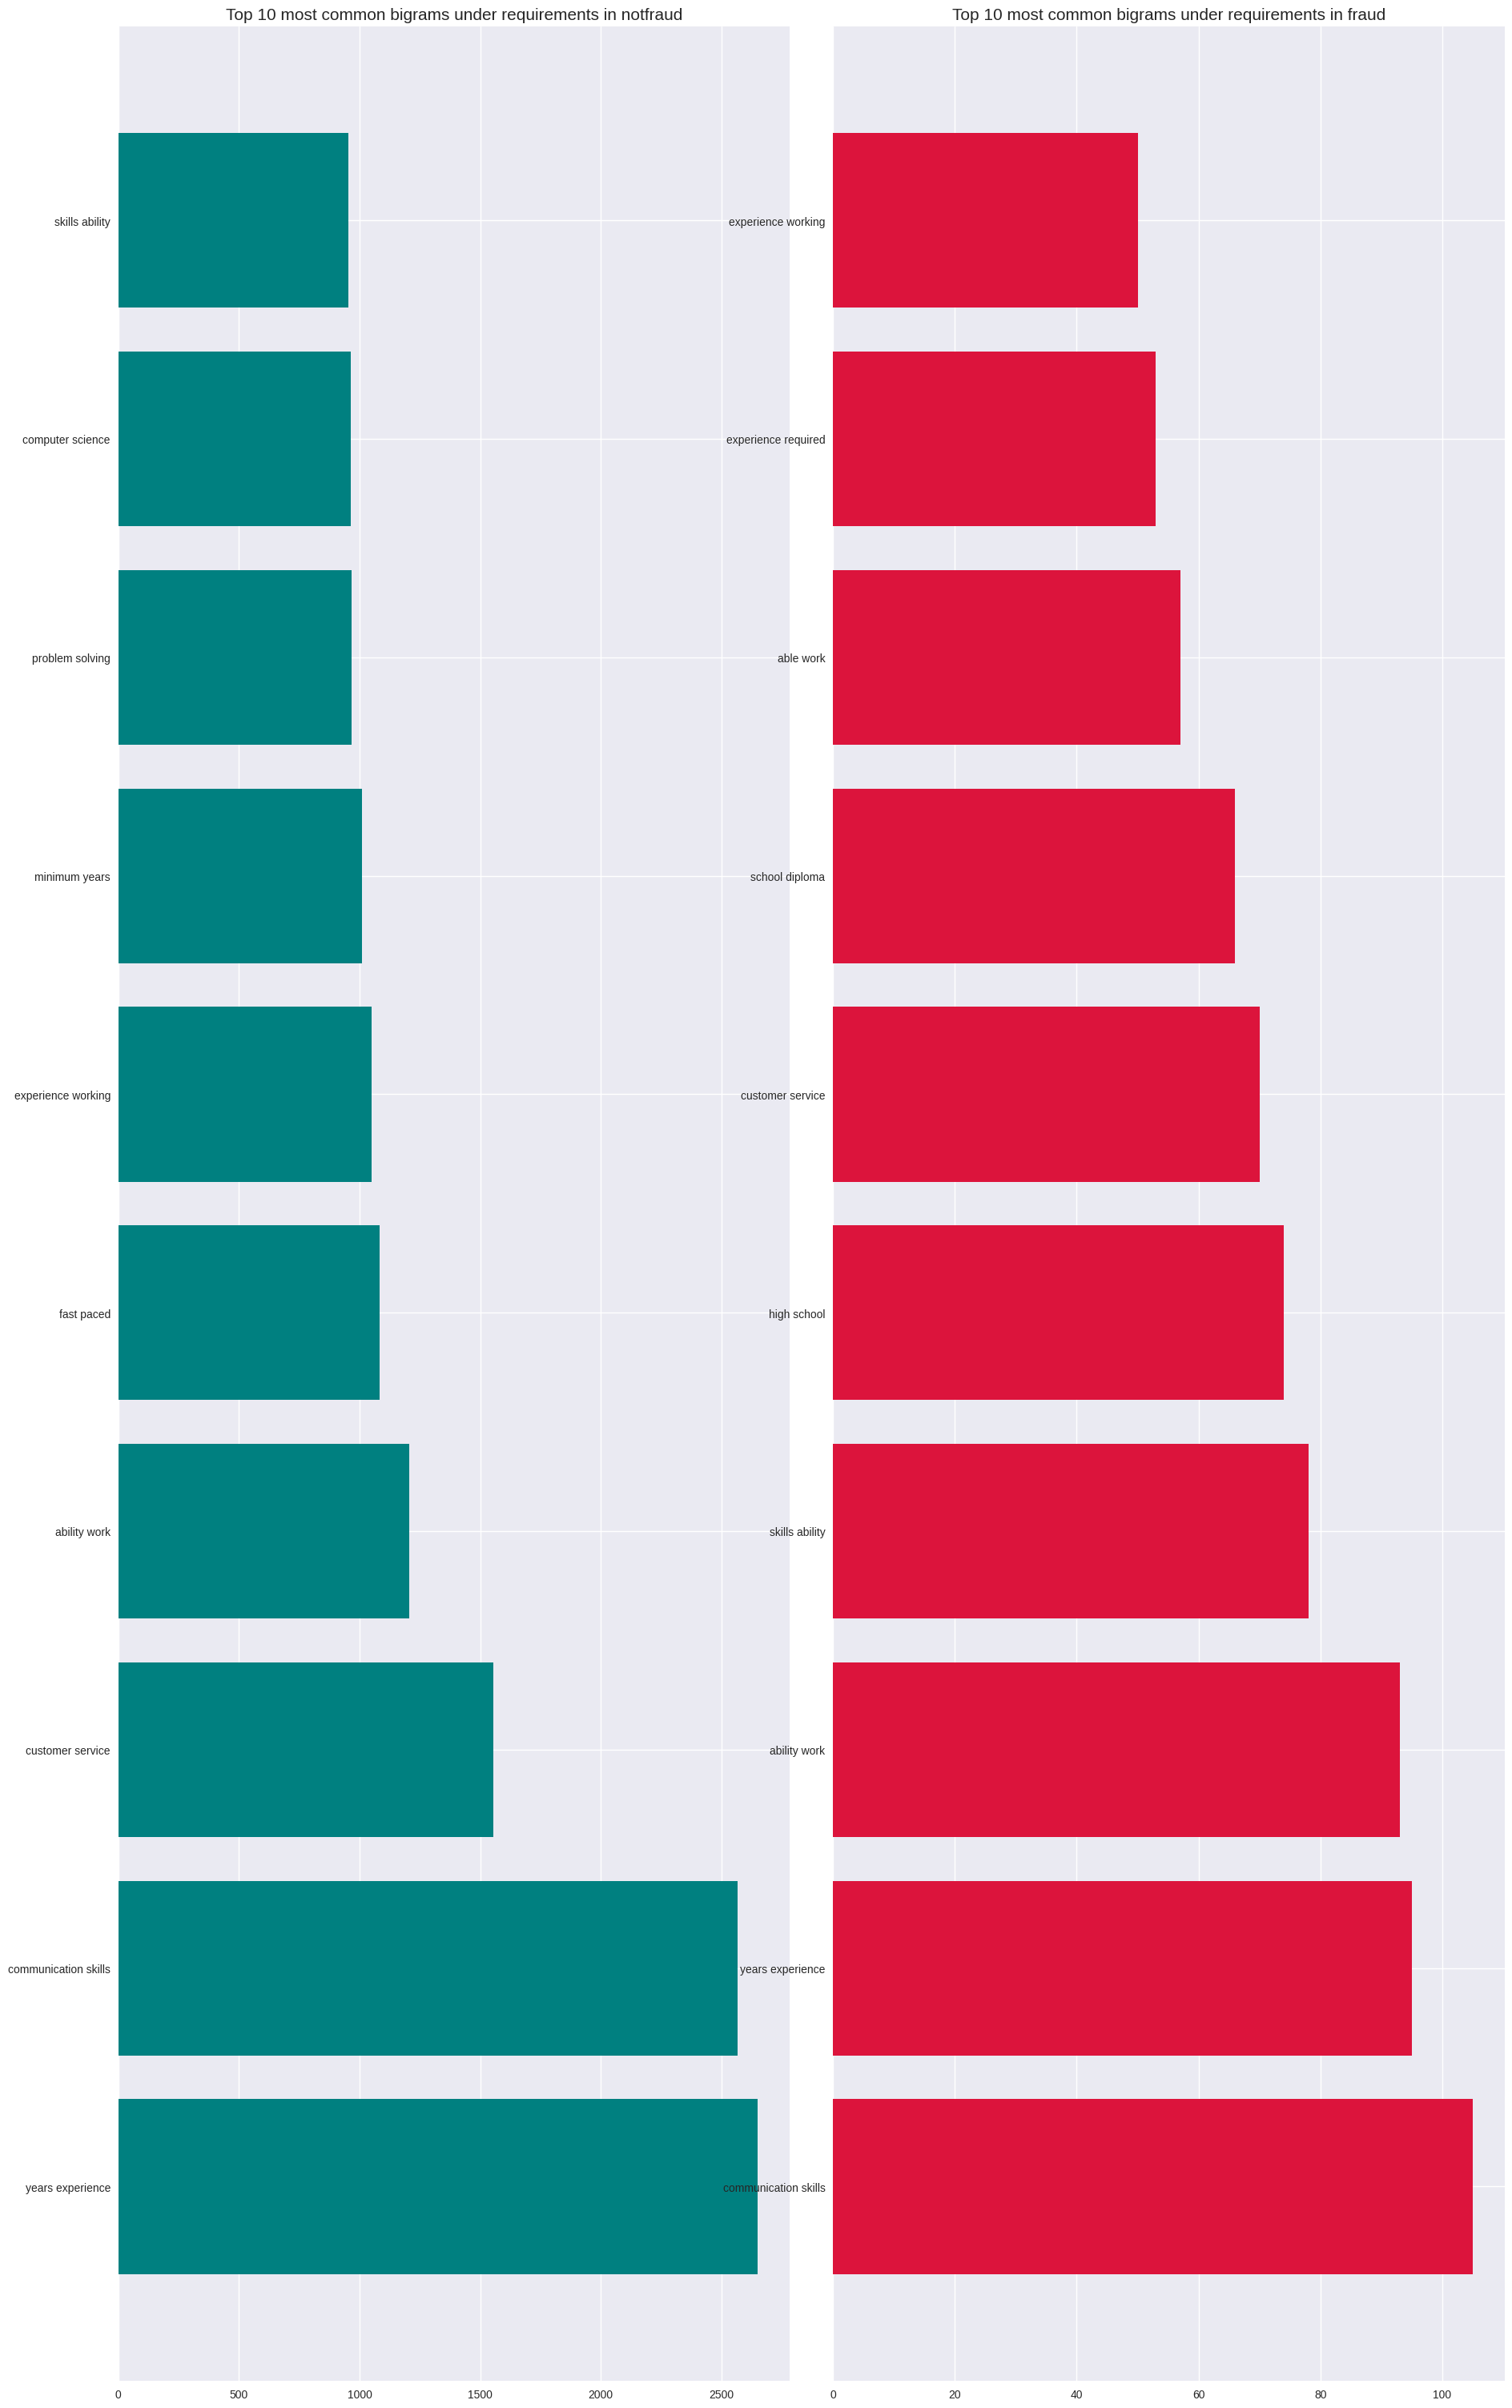

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

bigrams_notfraud=get_top_bigrams(notfraud_data['requirements'])
x,y=map(list,zip(*bigrams_notfraud))
axes[0].barh(x,y, color='teal')

bigrams_fraud=get_top_bigrams(fraud_data['requirements'])
x,y=map(list,zip(*bigrams_fraud))
axes[1].barh(x,y, color='crimson')

axes[0].set_title('Top 10 most common bigrams under requirements in notfraud', fontsize=15)
axes[1].set_title('Top 10 most common bigrams under requirements in fraud', fontsize=15)

plt.show()

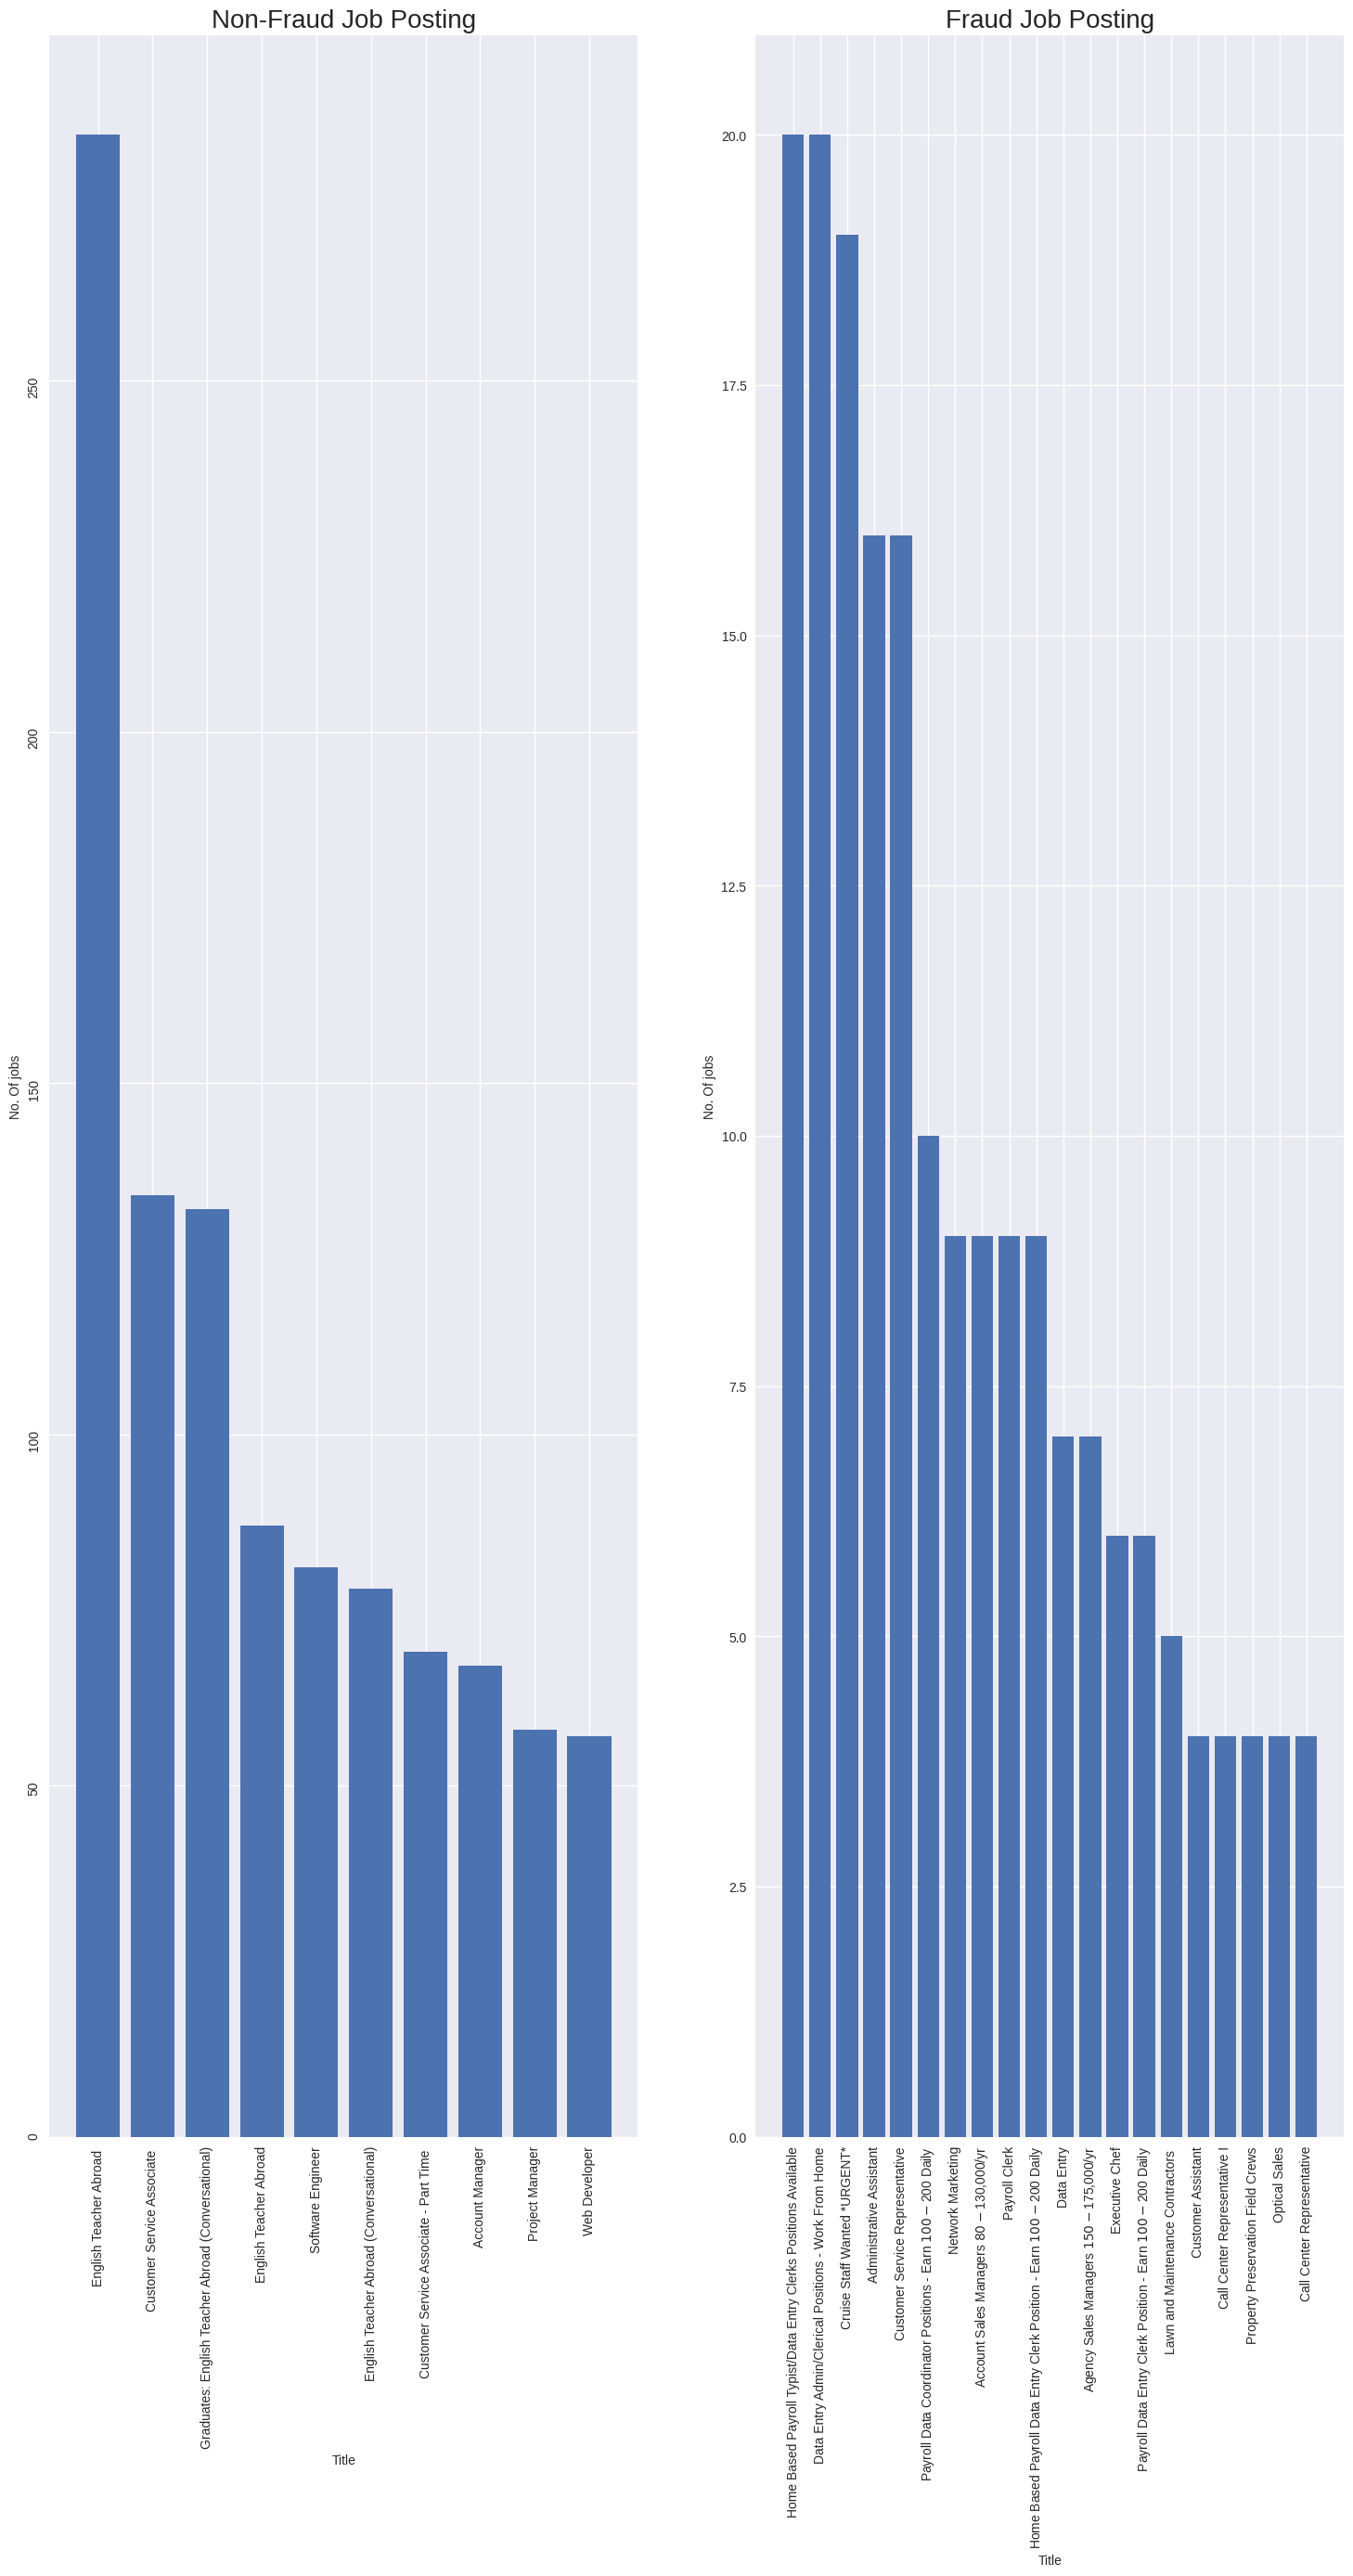

In [ ]:
#understand top 10 non fraud posting based on titles
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
nfraud = dict(notfraud_data.title.value_counts()[:10])

axes[0].set_title('Non-Fraud Job Posting',size=20)
axes[0].bar(nfraud.keys(),nfraud.values())
axes[0].set_ylabel('No. Of jobs',size=10)
axes[0].set_xlabel('Title', size=10)
axes[0].tick_params(labelrotation=90)

#understand top 20 fraud posting based on titles 
fraud = dict(fraud_data.title.value_counts()[:20])

axes[1].set_title('Fraud Job Posting',size=20)
axes[1].bar(fraud.keys(),fraud.values())
axes[1].set_ylabel('No. Of jobs',size=10)
axes[1].set_xlabel('Title', size=10)
plt.xticks(rotation=90)
plt.show()

In [ ]:
X_train.loc[:, 'Contains salary in title'] = X_train['title'].apply(lambda x: 1 if re.search(r'\bearn', x, re.I) else 0)
X_test.loc[:, 'Contains salary in title'] = X_test['title'].apply(lambda x: 1 if re.search(r'\bearn', x, re.I) else 0)
#X_val.loc[:, 'Contains salary in title'] = X_val['title'].apply(lambda x: 1 if re.search(r'\bearn', x, re.I) else 0)

In [ ]:
# Commented out because feature importance was not substantial
#X_train['req_cosine_sim'] = X_train['requirements'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
#X_test['req_cosine_sim'] = X_test['requirements'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))

In [ ]:
# Commented out because feature importance was not substantial
#X_train['industry_cosine_sim'] = X_train['industry'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
#X_test['industry_cosine_sim'] = X_test['industry'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))

In [ ]:
# Commented out because feature importance was not substantial
#X_train['function_cosine_sim'] = X_train['function'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))
#X_test['function_cosine_sim'] = X_test['function'].apply(lambda x: get_cosine_sim([y[0] for y in bigrams_fraud], x))

In [ ]:
X_train.head()

,job_id,title,location,country,state,city,department,salary_present,salary_range,lower_salary_range,...,edu_vocational,edu_vocational degree,edu_vocational hs diploma,industry,function,fraudulent,description_cosine_sim,title_cosine_sim,cp_cosine_sim,Contains salary in title
0,4695,Accountant,"GB, WSX, Crawley",GB,WSX,Crawley,Unspecified,0,NaN,NaN,...,0.0,0.0,0.0,Unspecified,Unspecified,0,0.191366,0.0,0.0,0
1,12341,Email Marketing Executive,"GB, SRY, Woking",GB,SRY,Woking,Unspecified,1,18000-25000,18000.0,...,0.0,0.0,0.0,Marketing and Advertising,Marketing,0,0.192435,0.0,0.0,0
2,5304,Email / Web Designer,"US, CA, San Diego / Orange County",US,CA,San Diego / Orange County,Unspecified,0,NaN,NaN,...,0.0,0.0,0.0,Design,Design,0,0.141905,0.0,0.0,0
3,13539,UX Engineer,"US, CA, Auburn",US,CA,Auburn,Unspecified,0,NaN,NaN,...,0.0,0.0,0.0,Computer Software,Engineering,0,0.133745,0.0,0.0,0
4,17300,Business Development Manager (Partnerships),"GB, LND, London",GB,LND,London,Partnerships,0,NaN,NaN,...,0.0,0.0,0.0,Financial Services,Sales,0,0.188042,0.0,0.0,0


In [ ]:
drop_cols = ['country', 'state', 'city', 'job_id', 'title', 'location', 'department', 'salary_present', 'salary_range', 'lower_salary_range', 'lower_salary_range_category', 'lowsal_unspecified', 'higher_salary_range', 'higher_salary_range_category', 'highsal_unspecified', 'salary_range_difference', 'salary_range_difference_category', 'saldiff_unspecified', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'employment_type', 'industry', 'function', 'required_experience', 'required_education', 'fraudulent']
X_train = X_train.drop(drop_cols, axis=1)
drop_cols.remove('fraudulent')
X_test = X_test.drop(drop_cols, axis=1)
# X_val = X_val.drop(drop_cols, axis=1)

## Training the Logistic Regression model on the Training set

In [ ]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
y_trainpred = classifier.predict(X_train) #evaluate model on training
#y_valpred = classifier.predict(X_val) #evaluate on test

## Model performance

In [ ]:
#For training data
print("-------------- For Training Data--------------")
cm = confusion_matrix(y_train, y_trainpred)
print(cm)
acc = accuracy_score(y_train, y_trainpred)
print(f'Accuracy: {acc}')
recall = recall_score(y_train, y_trainpred)
print(f'Recall: {recall}')
precision = precision_score(y_train, y_trainpred)
print(f'Precision: {precision}')
f1 = f1_score(y_train, y_trainpred)
print(f'F1 Score: {f1}')
auc_score = roc_auc_score(y_train, y_trainpred)
print("ROC_AUC: ", auc_score)

#For validation data
# print("-------------- For Validation Data--------------")
# cm = confusion_matrix(y_val, y_valpred)
# print(cm)
# acc = accuracy_score(y_val, y_valpred)
# print(f'Accuracy: {acc}')
# recall = recall_score(y_val, y_valpred)
# print(f'Recall: {recall}')
# precision = precision_score(y_val, y_valpred)
# print(f'Precision: {precision}')
# auc_score = roc_auc_score(y_val, y_valpred)
# print("ROC_AUC: ", auc_score)

-------------- For Training Data--------------
[[15261    31]
 [  612   188]]
Accuracy: 0.9600422570221228
Recall: 0.235
Precision: 0.8584474885844748
F1 Score: 0.3689892051030421
ROC_AUC:  0.6164863981166623


In [ ]:
feature_dict = {}
for i in range(len(classifier.coef_[0])):
    feature_dict[X_train.columns[i]] = classifier.coef_[0][i]
sorted(feature_dict.items(), key=lambda kv: kv[1])

[('has_company_logo', -2.3567580143163207),
 ('lowsal_outlier', -1.040871140144715),
 ('ep_temporary', -1.0019057983041255),
 ('edu_bachelor degree', -0.7333140068088562),
 ('edu_vocational', -0.7259965089135137),
 ('exp_associate', -0.49983614789350655),
 ('edu_some college coursework', -0.40432347018444376),
 ('highsal_low', -0.35931517274403935),
 ('edu_unspecified', -0.35243473577513557),
 ('highsal_high', -0.32230660827257773),
 ('exp_internship', -0.2625636256222447),
 ('ep_full-time', -0.25787792593162656),
 ('edu_associate degree', -0.24626682934567537),
 ('edu_vocational degree', -0.24573929398566424),
 ('exp_not applicable', -0.23094648530505488),
 ('edu_doctorate', -0.22474610517980523),
 ('exp_entry level', -0.20643569854266078),
 ('edu_vocational hs diploma', -0.15723584630767967),
 ('saldiff_low', -0.0799412940130453),
 ('saldiff_high', -0.05014018966035667),
 ('has_questions', -0.0388388676143702),
 ('ep_contract', -0.027082359235781634),
 ('exp_mid-senior level', -0.011

## Hyperparameter tuning

In [ ]:
classifier = LogisticRegression(random_state=0)
solvers = ['newton-cg', 'lbfgs', 'sag']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv=cv, n_jobs=-1, scoring='f1')
best_clf = grid_search.fit(X_train, y_train)

In [ ]:
y_trainpred = best_clf.predict(X_train) #evaluate model on training
#y_valpred = best_clf.predict(X_val) #evaluate on test

In [ ]:
#For training data
print("-------------- For Training Data--------------")
cm = confusion_matrix(y_train, y_trainpred)
print(cm)
acc = accuracy_score(y_trainpred, y_trainpred)
print(f'Accuracy: {acc}')
recall = recall_score(y_train, y_trainpred)
print(f'Recall: {recall}')
precision = precision_score(y_train, y_trainpred)
print(f'Precision: {precision}')
f1 = f1_score(y_train, y_trainpred)
print(f'F1 Score: {f1}')
auc_score = roc_auc_score(y_train, y_trainpred)
print("ROC Score: ", auc_score)

#For validation data
# print("-------------- For Validation Data--------------")
# cm = confusion_matrix(y_val, y_valpred)
# print(cm)
# acc = accuracy_score(y_val, y_valpred)
# print(f'Accuracy: {acc}')
# recall = recall_score(y_val, y_valpred)
# print(f'Recall: {recall}')
# precision = precision_score(y_val, y_valpred)
# print(f'Precision: {precision}')
# auc_score = roc_auc_score(y_val, y_valpred)
# print("ROC_AUC: ", auc_score)

-------------- For Training Data--------------
[[15259    33]
 [  601   199]]
Accuracy: 1.0
Recall: 0.24875
Precision: 0.8577586206896551
F1 Score: 0.3856589147286822
ROC Score:  0.6232960044467696


In [ ]:
print(best_clf.best_params_)
print(best_clf.best_score_)

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.37338624257383735


## Model evaluation on Test set

In [ ]:
y_testpred = best_clf.predict(X_test)
#For validation data
print("-------------- For Testing Data--------------")
cm = confusion_matrix(y_test, y_testpred)
print(cm)
acc = accuracy_score(y_test, y_testpred)
print(f'Accuracy: {acc}')
recall = recall_score(y_test, y_testpred)
print(f'Recall: {recall}')
precision = precision_score(y_test, y_testpred)
print(f'Precision: {precision}')
f1 = f1_score(y_train, y_trainpred)
print(f'F1 Score: {f1}')
auc_score = roc_auc_score(y_test, y_testpred)
print("ROC Score: ", auc_score)

-------------- For Testing Data--------------
[[1715    7]
 [  52   14]]
Accuracy: 0.9670022371364653
Recall: 0.21212121212121213
Precision: 0.6666666666666666
F1 Score: 0.3856589147286822
ROC Score:  0.6040280857354029


#Random Forest

In [ ]:
# X_train_full = pd.concat([X_train, X_val], ignore_index=True, axis=0)
# y_train_full = pd.concat([y_train, y_val], ignore_index=True, axis=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=150,
                              max_depth=20,
                              random_state = 1234,
                              criterion = 'entropy',
                              oob_score= True)
model_rf.fit(X_train, y_train)
y_predict_rf = model_rf.predict(X_train)

Accuracy Score: 0.9880686055182699
Precision Score: 0.9983606557377049
Recall Score: 0.76125
F1 Score: 0.8638297872340426
ROC Score: 0.9981882683756212
[[15291     1]
 [  191   609]]


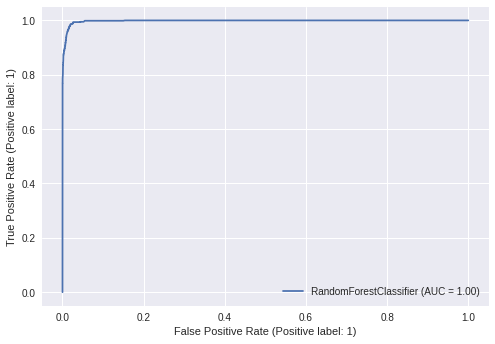

In [ ]:
print('Accuracy Score:', (accuracy_score(y_train, y_predict_rf)))
print('Precision Score:', (precision_score(y_train, y_predict_rf)))
print('Recall Score:', (recall_score(y_train, y_predict_rf)))
print('F1 Score:', (f1_score(y_train, y_predict_rf)))

y_score_rf = model_rf.predict_proba(X_train)
print('ROC Score:', (roc_auc_score(y_train, y_score_rf[:,1])))
print(confusion_matrix(y_train,y_predict_rf))
print(plot_roc_curve(model_rf, X_train, y_train))

In [ ]:
parameters = {'n_estimators': [150, 175, 200],
              'max_depth': [20, 25, 28], #[10,20,30]
              #'min_samples_leaf': [3],
              #'min_samples_split': [1,2],
              'random_state': [1234],
              'criterion' : ['entropy']}

model_tune = RandomForestClassifier()
rf_tune = GridSearchCV(model_tune,
                        parameters,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 3)

model_rf = rf_tune.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END criterion=entropy, max_depth=20, n_estimators=150, random_state=1234;, score=0.632 total time=   1.8s
[CV 2/3] END criterion=entropy, max_depth=20, n_estimators=150, random_state=1234;, score=0.679 total time=   1.7s
[CV 3/3] END criterion=entropy, max_depth=20, n_estimators=150, random_state=1234;, score=0.656 total time=   1.7s
[CV 1/3] END criterion=entropy, max_depth=20, n_estimators=175, random_state=1234;, score=0.632 total time=   2.0s
[CV 2/3] END criterion=entropy, max_depth=20, n_estimators=175, random_state=1234;, score=0.674 total time=   2.0s
[CV 3/3] END criterion=entropy, max_depth=20, n_estimators=175, random_state=1234;, score=0.656 total time=   2.0s
[CV 1/3] END criterion=entropy, max_depth=20, n_estimators=200, random_state=1234;, score=0.622 total time=   2.3s
[CV 2/3] END criterion=entropy, max_depth=20, n_estimators=200, random_state=1234;, score=0.678 total time=   2.2s
[CV 3/3] END criteri

{'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 175, 'random_state': 1234}
Accuracy Score: 0.9933507332836192
Precision Score: 0.9819193324061196
Recall Score: 0.8825
F1 Score: 0.9295589203423305
ROC Score: 0.999259743656814
[[15279    13]
 [   94   706]]


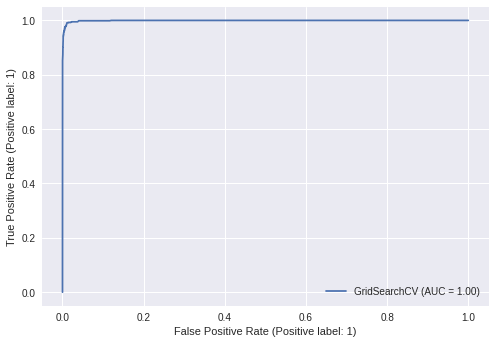

In [ ]:
print(model_rf.best_params_)

y_predict_rf = model_rf.predict(X_train)

print('Accuracy Score:', (accuracy_score(y_train, y_predict_rf)))
print('Precision Score:', (precision_score(y_train, y_predict_rf)))
print('Recall Score:', (recall_score(y_train, y_predict_rf)))
print('F1 Score:', (f1_score(y_train, y_predict_rf)))

y_score_rf = model_rf.predict_proba(X_train)
print('ROC Score:', (roc_auc_score(y_train, y_score_rf[:,1])))
print(confusion_matrix(y_train,y_predict_rf))
print(plot_roc_curve(model_rf, X_train, y_train))

Accuracy Score: 0.9809843400447428
Precision Score: 0.8076923076923077
Recall Score: 0.6363636363636364
F1 Score: 0.7118644067796609
ROC Score: 0.9714743251328617
[[1712   10]
 [  24   42]]


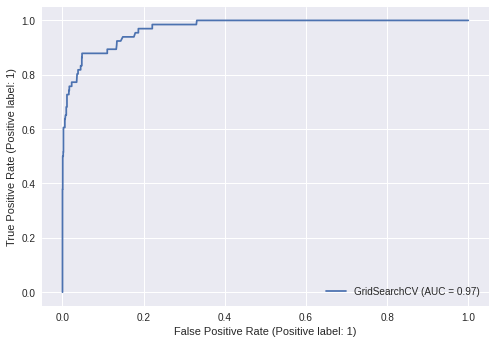

In [ ]:
#Ytest
y_predict_test = model_rf.predict(X_test)

print('Accuracy Score:', (accuracy_score(y_test, y_predict_test)))
print('Precision Score:', (precision_score(y_test, y_predict_test)))
print('Recall Score:', (recall_score(y_test, y_predict_test)))
print('F1 Score:', (f1_score(y_test, y_predict_test)))

y_score_test = model_rf.predict_proba(X_test)
print('ROC Score:', (roc_auc_score(y_test, y_score_test[:,1])))

print(confusion_matrix(y_test,y_predict_test))
print(plot_roc_curve(model_rf, X_test, y_test))

In [ ]:
rf_importances = model_rf.best_estimator_.feature_importances_
# rf_std = np.std([tree.feature_importances_ for tree in model_rf.best_estimator_.estimators_], axis=0)

feature_names = [f"{i}" for i in list(X_test.columns)]
forest_importances = pd.Series(rf_importances, index=feature_names)
most_important = forest_importances[forest_importances > 0.05]
most_important = most_important.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

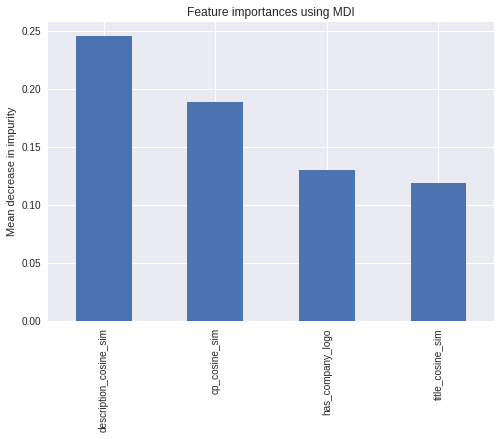

In [ ]:
fig, ax = plt.subplots()
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

#Decision Tree



In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_tree = DecisionTreeClassifier(max_depth=23,
                               min_samples_split=6,
                               random_state=1234,
                               criterion = 'entropy')
model_tree.fit(X_train, y_train)
y_predict_tree = model_tree.predict(X_train)

Accuracy Score: 0.9885657469550087
Precision Score: 0.9289693593314763
Recall Score: 0.83375
F1 Score: 0.8787878787878787
ROC Score: 0.999259743656814
[[15241    51]
 [  133   667]]


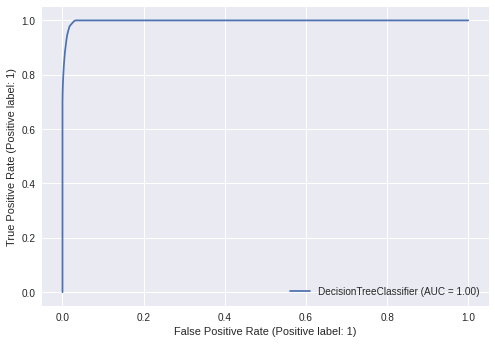

In [ ]:
print('Accuracy Score:', (accuracy_score(y_train, y_predict_tree)))
print('Precision Score:', (precision_score(y_train, y_predict_tree)))
print('Recall Score:', (recall_score(y_train, y_predict_tree)))
print('F1 Score:', (f1_score(y_train, y_predict_tree)))

y_score_tree = model_rf.predict_proba(X_train)
print('ROC Score:', (roc_auc_score(y_train, y_score_tree[:,1])))
print(confusion_matrix(y_train,y_predict_tree))
print(plot_roc_curve(model_tree, X_train, y_train))

In [ ]:
parameters = {'max_depth': [21, 23, 25],
              'min_samples_split': [ 5,6,7,8,9],
              'criterion' : ['gini', 'entropy'],
              'random_state': [1234]}

In [ ]:
%%time
model_tune = DecisionTreeClassifier()
tree_tune = GridSearchCV(model_tune,
                        parameters,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 3)

model_tree = tree_tune.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END criterion=gini, max_depth=21, min_samples_split=5, random_state=1234;, score=0.598 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=21, min_samples_split=5, random_state=1234;, score=0.635 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=21, min_samples_split=5, random_state=1234;, score=0.617 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=21, min_samples_split=6, random_state=1234;, score=0.599 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=21, min_samples_split=6, random_state=1234;, score=0.627 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=21, min_samples_split=6, random_state=1234;, score=0.633 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=21, min_samples_split=7, random_state=1234;, score=0.605 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=21, min_samples_split=7, random_state=1234;, score=0.631 total time=   0.1s
[CV 3/3] END criter

{'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 5, 'random_state': 1234}
Accuracy Score: 0.9910514541387024
Precision Score: 0.9517906336088154
Recall Score: 0.86375
F1 Score: 0.9056356487549149
ROC Score: 0.998806320298195
[[15257    35]
 [  109   691]]


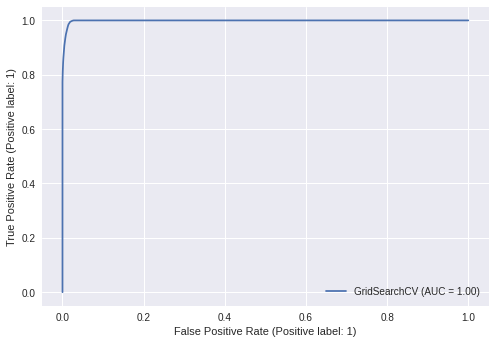

In [ ]:
print(model_tree.best_params_)

y_predict_tree = model_tree.predict(X_train)

print('Accuracy Score:', (accuracy_score(y_train, y_predict_tree)))
print('Precision Score:', (precision_score(y_train, y_predict_tree)))
print('Recall Score:', (recall_score(y_train, y_predict_tree)))
print('F1 Score:', (f1_score(y_train, y_predict_tree)))

y_score_tree = model_tree.predict_proba(X_train)
print('ROC Score:', (roc_auc_score(y_train, y_score_tree[:,1])))

print(confusion_matrix(y_train, y_predict_tree))
print(plot_roc_curve(model_tree, X_train, y_train))

Accuracy Score: 0.9670022371364653
Precision Score: 0.5507246376811594
Recall Score: 0.5757575757575758
F1 Score: 0.562962962962963
ROC Score: 0.9714743251328617
[[1691   31]
 [  28   38]]


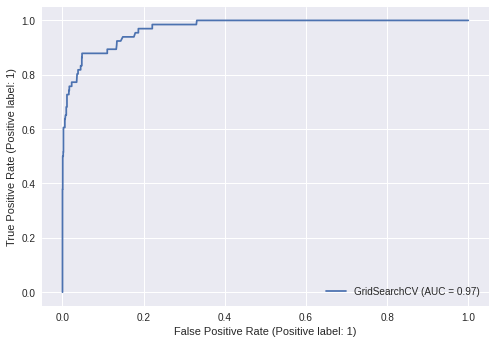

In [ ]:
y_predict_test = model_tree.predict(X_test)

print('Accuracy Score:', (accuracy_score(y_test, y_predict_test)))
print('Precision Score:', (precision_score(y_test, y_predict_test)))
print('Recall Score:', (recall_score(y_test, y_predict_test)))
print('F1 Score:', (f1_score(y_test, y_predict_test)))

y_score_test = model_rf.predict_proba(X_test)
print('ROC Score:', (roc_auc_score(y_test, y_score_test[:,1])))

print(confusion_matrix(y_test,y_predict_test))
print(plot_roc_curve(model_rf, X_test, y_test))

#SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_svm0 = SVC(probability=True, class_weight={1: 1000}).fit(X_train, y_train)

y_predict_svm0 = model_svm0.predict(X_train)

print('Accuracy Score:', (accuracy_score(y_train, y_predict_svm0)))
print('Precision Score:', (precision_score(y_train, y_predict_svm0)))
print('Recall Score:', (recall_score(y_train, y_predict_svm0)))
print('F1 Score:', (f1_score(y_train, y_predict_svm0)))

y_score_svm0 = model_svm0.predict_proba(X_train)
print('ROC Score:', (roc_auc_score(y_train, y_score_svm0[:,1])))

Accuracy Score: 0.6736887894606015
Precision Score: 0.13220955214014213
Recall Score: 1.0
F1 Score: 0.2335425485330609
ROC Score: 0.9335163811143081


In [ ]:
svm_parameters = {'C': np.logspace(-1, 1, 3),
                  'kernel': ('linear', 'poly','rbf'),
                  'degree': [2,3]}

In [ ]:
%%time
model_svm = GridSearchCV(estimator=SVC(probability=True),
                         param_grid= svm_parameters,
                         cv = 2,
                         scoring='f1',
                         verbose = 3).fit(X_train, y_train)
pd.DataFrame(model_svm.cv_results_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END ....C=0.1, degree=2, kernel=linear;, score=0.100 total time=   3.8s
[CV 2/2] END ....C=0.1, degree=2, kernel=linear;, score=0.063 total time=   4.1s
[CV 1/2] END ......C=0.1, degree=2, kernel=poly;, score=0.232 total time=   3.8s
[CV 2/2] END ......C=0.1, degree=2, kernel=poly;, score=0.190 total time=   3.9s
[CV 1/2] END .......C=0.1, degree=2, kernel=rbf;, score=0.148 total time=   5.7s
[CV 2/2] END .......C=0.1, degree=2, kernel=rbf;, score=0.118 total time=   6.1s
[CV 1/2] END ....C=0.1, degree=3, kernel=linear;, score=0.100 total time=   4.0s
[CV 2/2] END ....C=0.1, degree=3, kernel=linear;, score=0.063 total time=   4.3s
[CV 1/2] END ......C=0.1, degree=3, kernel=poly;, score=0.309 total time=   3.8s
[CV 2/2] END ......C=0.1, degree=3, kernel=poly;, score=0.264 total time=   3.8s
[CV 1/2] END .......C=0.1, degree=3, kernel=rbf;, score=0.148 total time=   5.8s
[CV 2/2] END .......C=0.1, degree=3, kernel=rbf;

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,3.642346,0.153930,0.321362,0.000499,0.1,2,linear,"{'C': 0.1, 'degree': 2, 'kernel': 'linear'}",0.099762,0.062802,0.081282,0.018480,17
1,3.525846,0.058927,0.348913,0.007786,0.1,2,poly,"{'C': 0.1, 'degree': 2, 'kernel': 'poly'}",0.232456,0.190045,0.211251,0.021205,10
2,5.067290,0.166228,0.862666,0.023095,0.1,2,rbf,"{'C': 0.1, 'degree': 2, 'kernel': 'rbf'}",0.147806,0.117647,0.132727,0.015079,11
3,3.850124,0.163381,0.323106,0.000514,0.1,3,linear,"{'C': 0.1, 'degree': 3, 'kernel': 'linear'}",0.099762,0.062802,0.081282,0.018480,17
4,3.468767,0.002226,0.377724,0.002941,0.1,3,poly,"{'C': 0.1, 'degree': 3, 'kernel': 'poly'}",0.308977,0.264069,0.286523,0.022454,9
5,5.215259,0.245476,0.848156,0.018893,0.1,3,rbf,"{'C': 0.1, 'degree': 3, 'kernel': 'rbf'}",0.147806,0.117647,0.132727,0.015079,11
6,4.228909,0.250987,0.333242,0.013496,1.0,2,linear,"{'C': 1.0, 'degree': 2, 'kernel': 'linear'}",0.107477,0.116279,0.111878,0.004401,13
7,3.364528,0.086043,0.320986,0.013074,1.0,2,poly,"{'C': 1.0, 'degree': 2, 'kernel': 'poly'}",0.402321,0.448980,0.425650,0.023329,8
8,4.996586,0.053889,0.789968,0.026850,1.0,2,rbf,"{'C': 1.0, 'degree': 2, 'kernel': 'rbf'}",0.436090,0.480734,0.458412,0.022322,6
9,4.511978,0.308705,0.336588,0.016377,1.0,3,linear,"{'C': 1.0, 'degree': 3, 'kernel': 'linear'}",0.107477,0.116279,0.111878,0.004401,13


In [ ]:
print(model_svm.best_params_)

y_predict_svm = model_svm.predict(X_train)

print('Accuracy Score:', (accuracy_score(y_train, y_predict_svm)))
print('Precision Score:', (precision_score(y_train, y_predict_svm)))
print('Recall Score:', (recall_score(y_train, y_predict_svm)))
print('F1 Score:', (f1_score(y_train, y_predict_svm)))

y_score_svm = model_svm.predict_proba(X_train)
print('ROC Score:', (roc_auc_score(y_train, y_score_svm[:,1])))

{'C': 10.0, 'degree': 2, 'kernel': 'rbf'}
Accuracy Score: 0.972532935620184
Precision Score: 0.9049773755656109
Recall Score: 0.5
F1 Score: 0.6441223832528181
ROC Score: 0.9676388798064347


[[15250    42]
 [  400   400]]


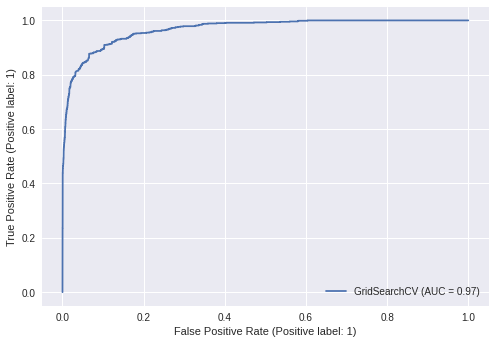

In [ ]:
print(confusion_matrix(y_train,y_predict_svm))
print(plot_roc_curve(model_svm, X_train, y_train))

In [ ]:
import keras
import tensorflow as tf
new_y_train = y_train.copy()
new_y_train = new_y_train.replace(0,2)
new_y_train = new_y_train.replace(1,0)
new_y_train = new_y_train.replace(2,0)

nnmodel = keras.models.Sequential() 
nnmodel.add(keras.layers.Flatten(input_shape=[45]))
nnmodel.add(keras.layers.Dense(500, activation='ReLU'))
nnmodel.add(keras.layers.Dense(400, activation='ReLU'))
nnmodel.add(keras.layers.Dense(400, activation='ReLU'))
nnmodel.add(keras.layers.Dense(400, activation='ReLU'))
nnmodel.add(keras.layers.Dense(200, activation='ReLU'))
nnmodel.add(keras.layers.Dense(100, activation='ReLU'))
nnmodel.add(keras.layers.Dense(1, activation='sigmoid'))

nnmodel.compile(metrics=['AUC'],
              loss='mse',
              optimizer='sgd')

In [ ]:
history = nnmodel.fit(X_train,y_train, epochs=10)

Epoch 1/10
503/503 [==============================] - 7s 12ms/step - loss: 0.1073 - auc: 0.5206
Epoch 2/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0479 - auc: 0.6537
Epoch 3/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0465 - auc: 0.7414
Epoch 4/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0462 - auc: 0.7542
Epoch 5/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0460 - auc: 0.7632
Epoch 6/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0459 - auc: 0.7733
Epoch 7/10
503/503 [==============================] - 7s 15ms/step - loss: 0.0457 - auc: 0.7764
Epoch 8/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0455 - auc: 0.7809
Epoch 9/10
503/503 [==============================] - 7s 13ms/step - loss: 0.0453 - auc: 0.7855
Epoch 10/10
503/503 [==============================] - 6s 12ms/step - loss: 0.0450 - auc: 0.7906


503/503 [==============================] - 3s 5ms/step
Accuracy Score: 0.9502858563261248
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0


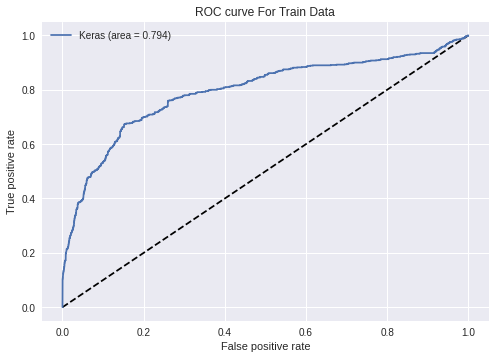

In [ ]:
from sklearn.metrics import auc
y_pred_keras_train = nnmodel.predict(X_train).ravel()
fpr_nn_train, tpr_nn_train, thresholds_nn_train = roc_curve(y_train, y_pred_keras_train)
auc_nn_train = auc(fpr_nn_train, tpr_nn_train)

y_predict_nn_round_train = y_pred_keras_train.round(0)

print('Accuracy Score:', (accuracy_score(y_train, y_predict_nn_round_train)))
print('Precision Score:', (precision_score(y_train, y_predict_nn_round_train)))
print('Recall Score:', (recall_score(y_train, y_predict_nn_round_train)))
print('F1 Score:', (f1_score(y_train, y_predict_nn_round_train)))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nn_train, tpr_nn_train, label='Keras (area = {:.3f})'.format(auc_nn_train))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve For Train Data')
plt.legend(loc='best')
plt.show()

56/56 [==============================] - 1s 9ms/step - loss: 0.0346 - auc: 0.7345
Model loss: 0.034641
Model accuracy: 0.734549
56/56 [==============================] - 1s 9ms/step
Accuracy Score: 0.9630872483221476
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0
56/56 [==============================] - 1s 10ms/step


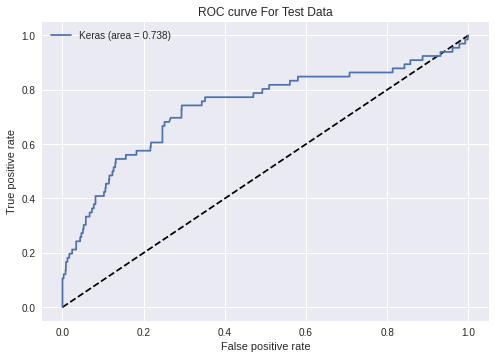

In [ ]:
result = nnmodel.evaluate(X_test, y_test)
print('Model loss: %f' % result[0])
print('Model accuracy: %f' % result[1])

y_predict_nn_test = nnmodel.predict(X_test)
y_predict_nn_round = y_predict_nn_test.round(0)

print('Accuracy Score:', (accuracy_score(y_test, y_predict_nn_round)))
print('Precision Score:', (precision_score(y_test, y_predict_nn_round)))
print('Recall Score:', (recall_score(y_test, y_predict_nn_round)))
print('F1 Score:', (f1_score(y_test, y_predict_nn_round)))

y_pred_keras = nnmodel.predict(X_test).ravel()
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_keras)
auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nn, tpr_nn, label='Keras (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve For Test Data')
plt.legend(loc='best')
plt.show()